In [15]:
from process_signals import *
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='The test statistic is outside of the range of p-values')
warnings.filterwarnings('ignore', category=UserWarning, message='No frequency information was provided, so inferred frequency D will be used.')

In [16]:
data = pd.read_csv('./data/consumo.csv', encoding="utf-8", thousands=".", decimal=",")
print(data.shape)
data.head(7)

(3073, 15)


AÑO     MES     Fecha                Tipo día  GRAN BS.AS.  BUENOS AIRES  \
0  2017  ene-17  1/1/2017       Domingo o Feriado       6352.7        1472.3   
1  2017  ene-17  2/1/2017           Lunes habiles       6617.9        1779.4   
2  2017  ene-17  3/1/2017          Martes Habiles       6678.0        1889.0   
3  2017  ene-17  4/1/2017       Miercoles habiles       6427.0        1840.6   
4  2017  ene-17  5/1/2017          Jueves Habiles       5874.0        1770.9   
5  2017  ene-17  6/1/2017         Viernes habiles       5781.1        1801.1   
6  2017  ene-17  7/1/2017  Sabado o Semilaborable       6231.7        1862.7   

   CENTRO  LITORAL    CUYO  NOROESTE  NORESTE  COMAHUE  PATAGONICA  \
0  1134.4   1766.6   903.1    1602.1   1400.3    561.2       500.9   
1  1363.5   1963.9  1091.8    1627.6   1585.6    638.8       540.6   
2  1600.7   2036.3  1178.7    1806.5   1653.0    624.6       536.5   
3  1356.4   1756.6  1078.9    1759.9   1604.8    598.4       528.9   
4  1366.0   1848.4  1037.8    1403.5   1228.3    585.2       524.7   
5  1367.4   1929.8  1135.5    1354.6   1218.7    615.5       550.9   
6  1388.8   2042.9  1161.9    1425.7   1306.4    626.4       533.9   

   DEMANDA TOTAL  TEMPERATURA REFERENCIA MEDIA GBA °C  
0        15693.7                                 31.3  
1        17209.2                                 25.4  
2        18003.4                                 25.5  
3        16951.5                                 27.0  
4        15638.8                                 21.9  
5        15754.5                                 24.3  
6        16580.5                                 29.1

In [17]:
data['Fecha'] = pd.to_datetime(data['Fecha'], format='%d/%m/%Y')
data.set_index('Fecha', inplace=True)

# Verificación de datos nulos o faltantes

In [18]:
print(data.isnull().sum())
print('Datos totales', data.shape[0])
print('Cantidad de días', (data.index[-1] - data.index[0]).days)

AÑO                                    0
MES                                    0
Tipo día                               0
GRAN BS.AS.                            0
BUENOS AIRES                           0
CENTRO                                 0
LITORAL                                0
CUYO                                   0
NOROESTE                               0
NORESTE                                0
COMAHUE                                0
PATAGONICA                             0
DEMANDA TOTAL                          0
TEMPERATURA REFERENCIA MEDIA GBA °C    0
dtype: int64
Datos totales 3073
Cantidad de días 3072


In [19]:
 # Separamos todas las series de tiempo
apodos = ['AMBA', 'CABA', 'CENTRO', 'LITORAL', 'CUYO', 'NOESTE', 'NESTE', 'COMAHUE', 'PATAG', 'TOTAL']
series = {}
for col in ['GRAN BS.AS.','BUENOS AIRES','CENTRO','LITORAL','CUYO','NOROESTE','NORESTE','COMAHUE','PATAGONICA','DEMANDA TOTAL']:
    series[col] = {}
    series[col]['ORIGINAL'] = data[col].dropna()
    series[col]['APODO'] = apodos.pop(0)

# series = {}
# series['DEMANDA TOTAL'] = {}
# series['DEMANDA TOTAL']['ORIGINAL'] = data['DEMANDA TOTAL'].dropna()
# series['DEMANDA TOTAL']['APODO'] = 'TOTAL'

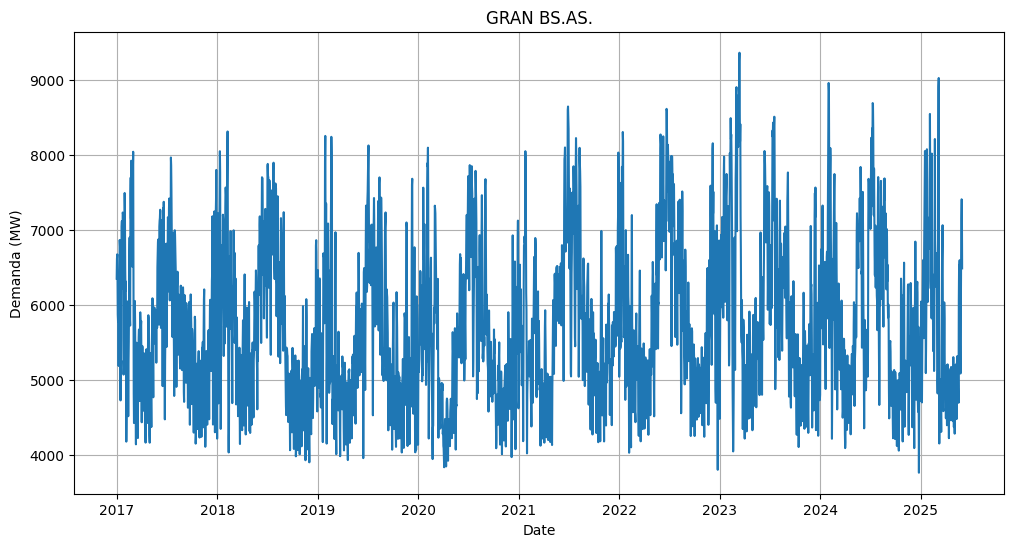

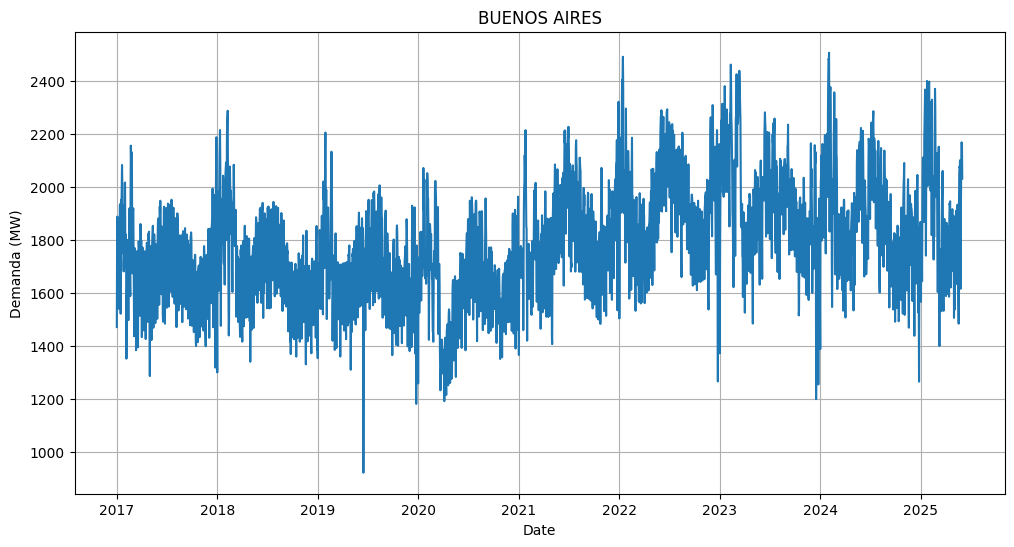

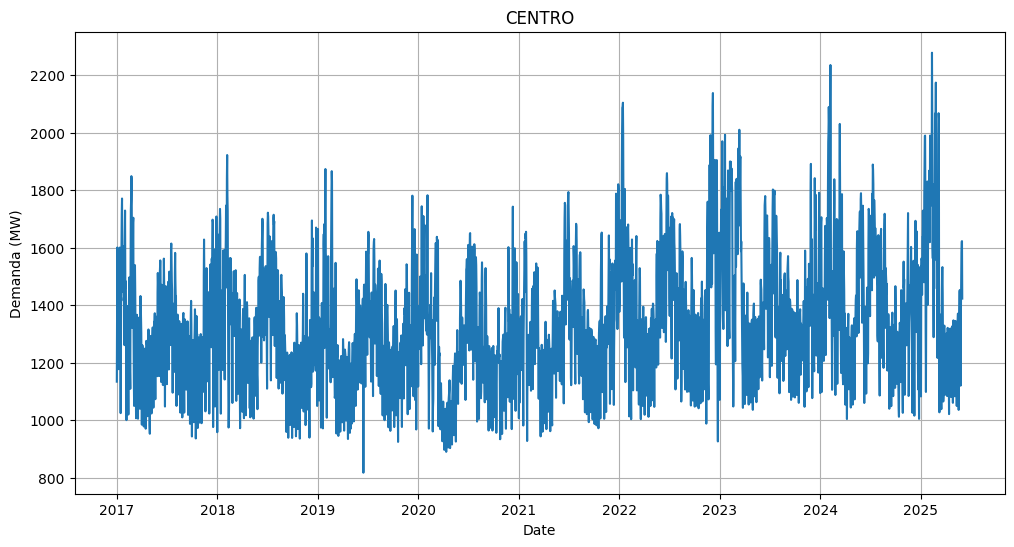

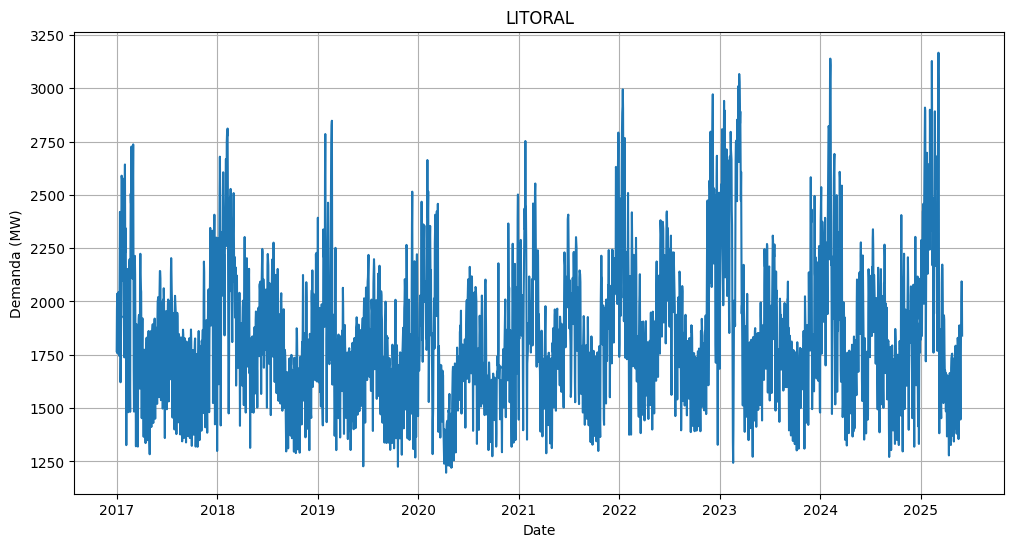

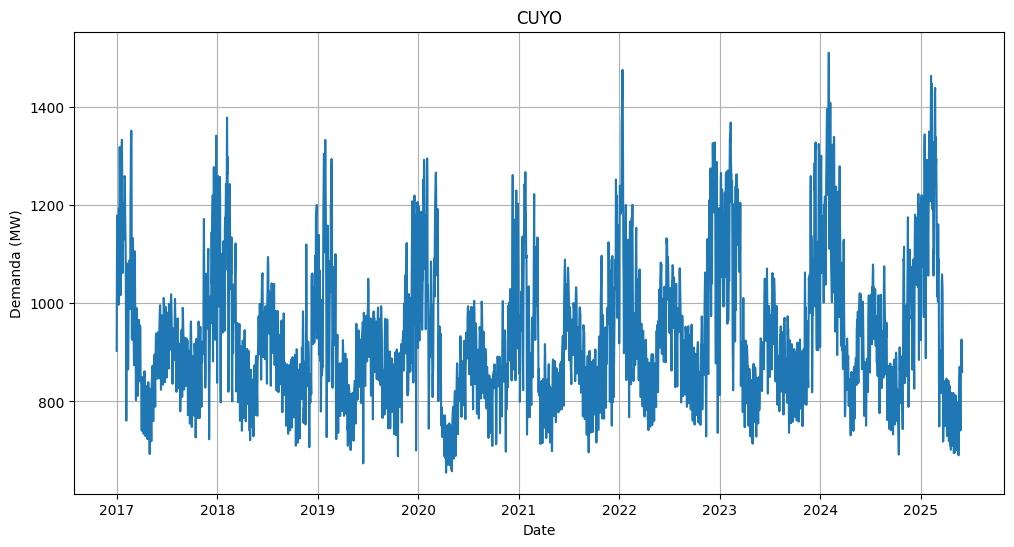

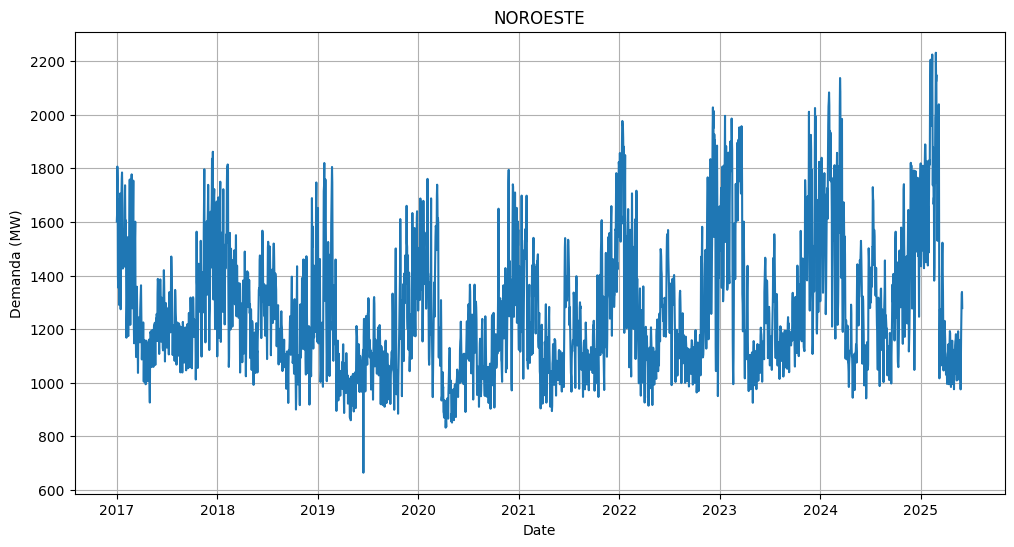

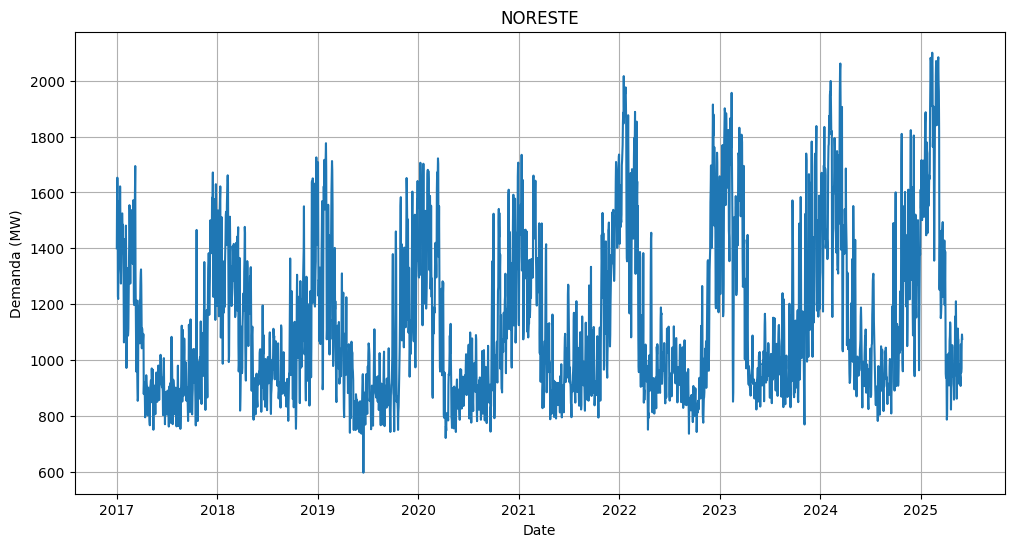

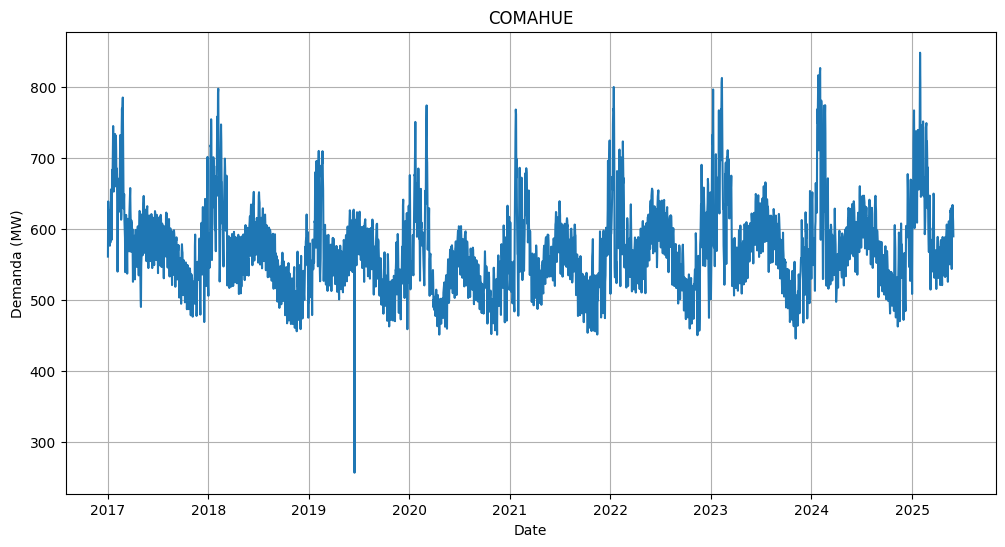

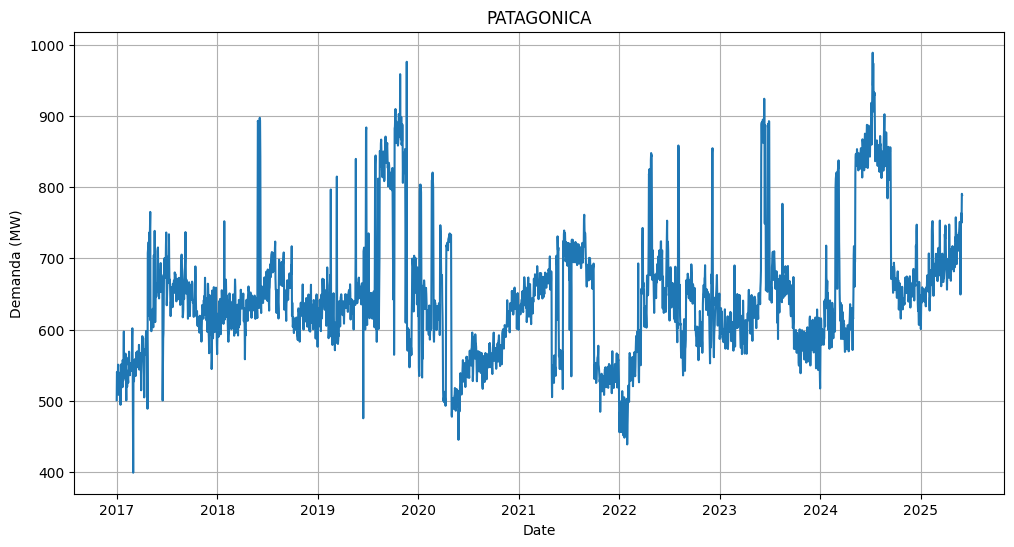

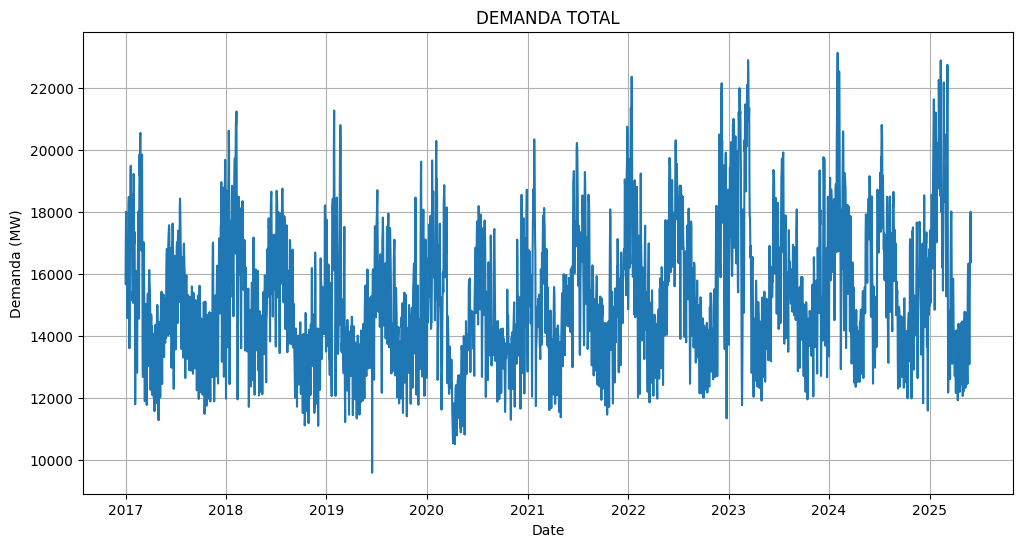

In [20]:
# Plot series
for col, serie in series.items():
    plot_series(serie['ORIGINAL'], title=col)

In [21]:
# Ubicamos el pico bajo de demanda
idxmindata = series['DEMANDA TOTAL']['ORIGINAL'].idxmin().date()
print(f"Fecha del pico bajo de demanda: {idxmindata}")
# Causa: "Apagón del siglo"

Fecha del pico bajo de demanda: 2019-06-16


# Filtros de Media movil.
### Trabajamos con MA30 para obtener mejores resultados

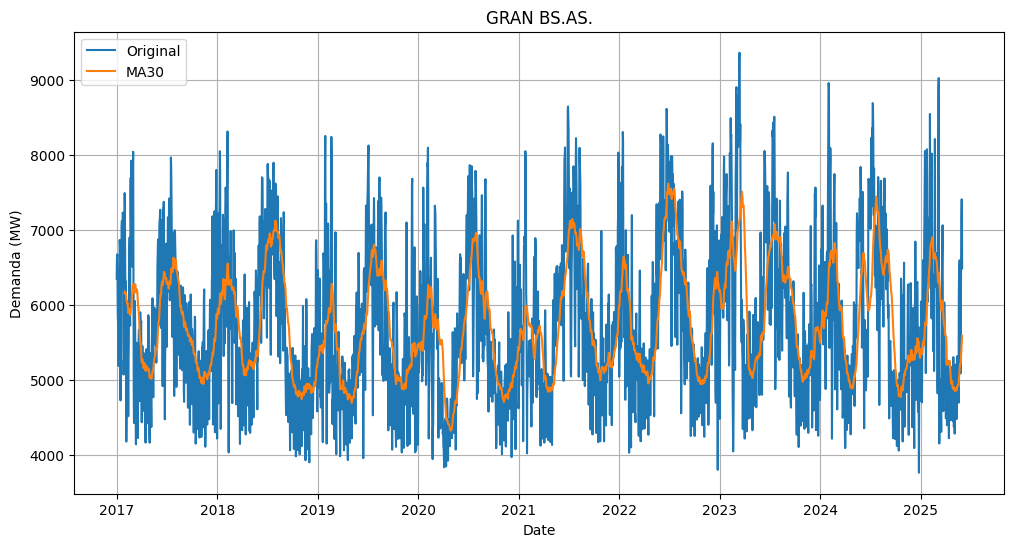

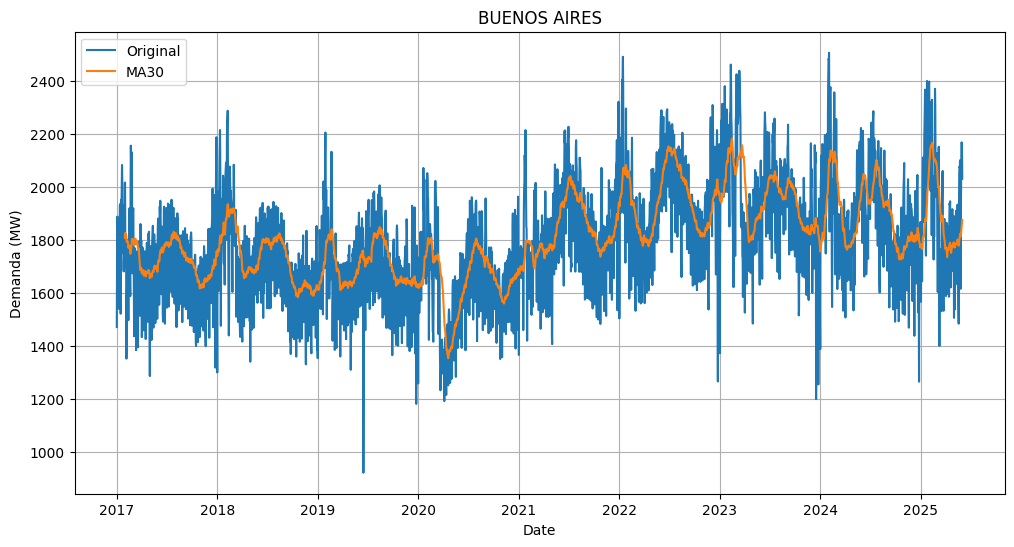

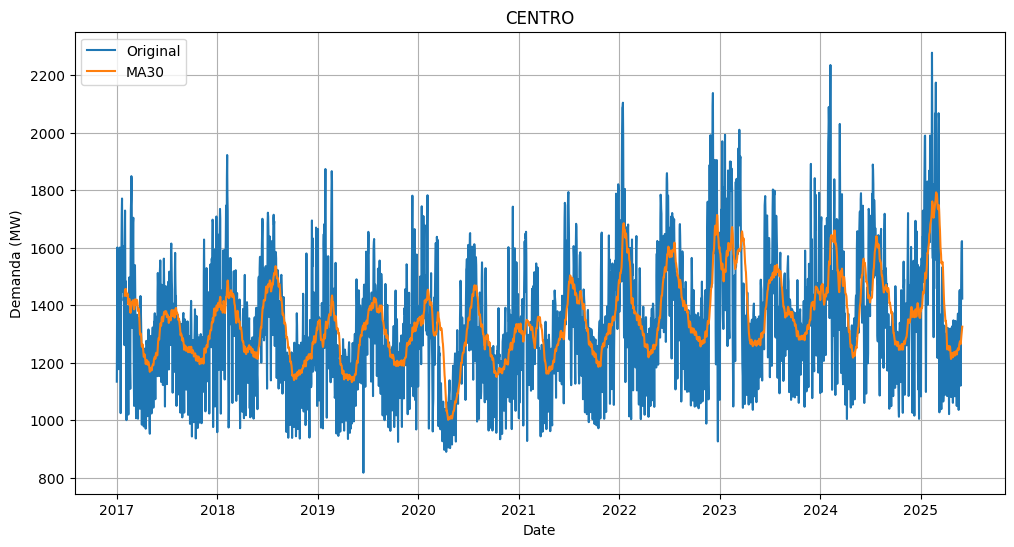

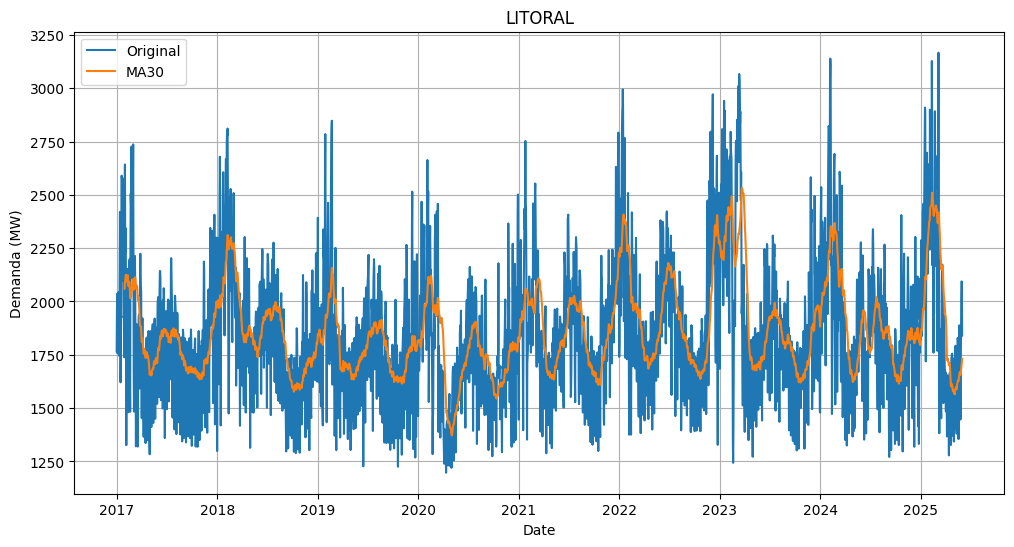

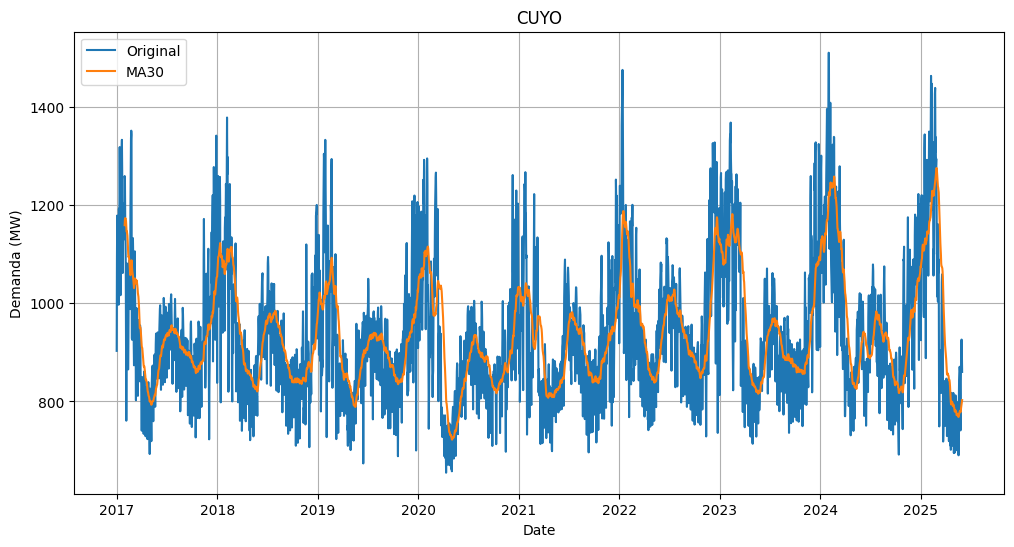

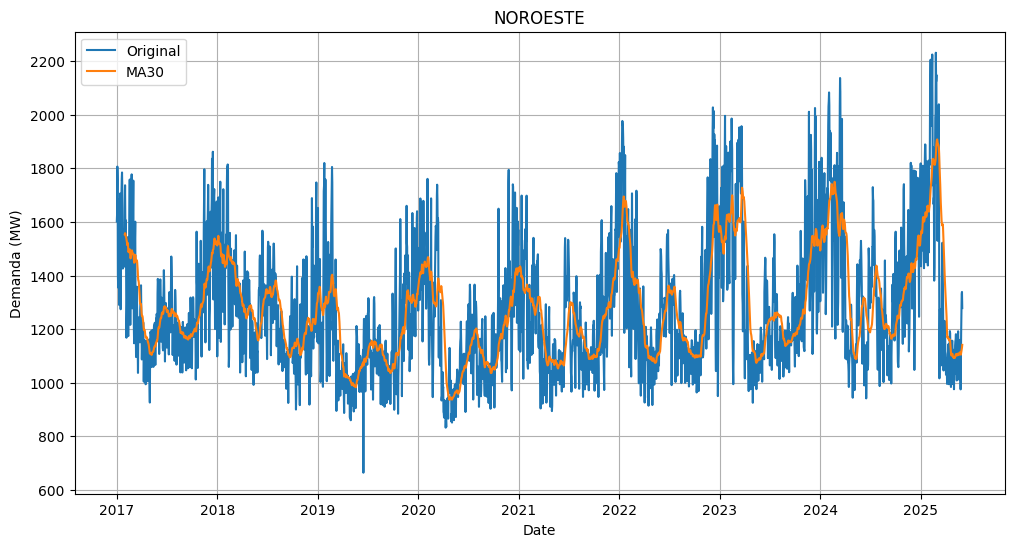

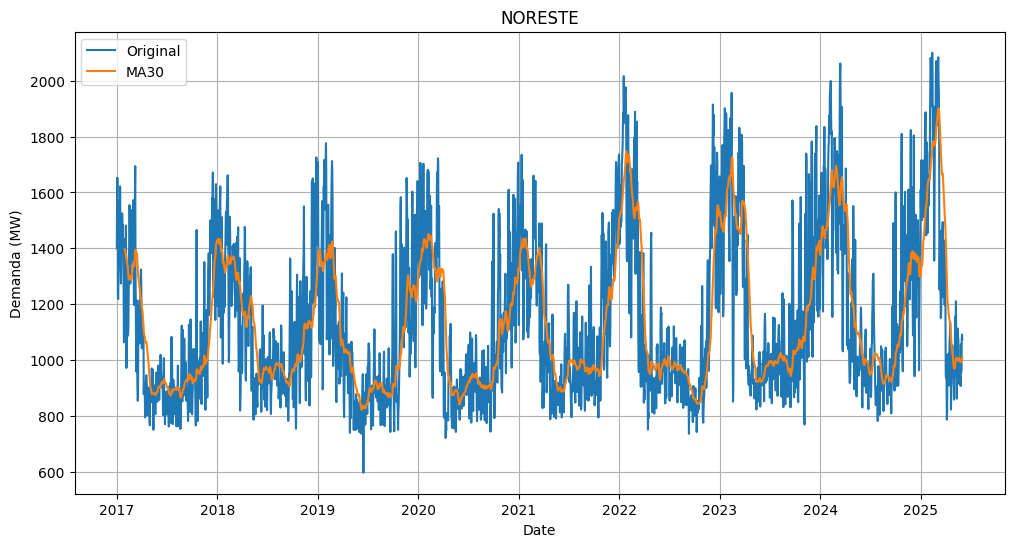

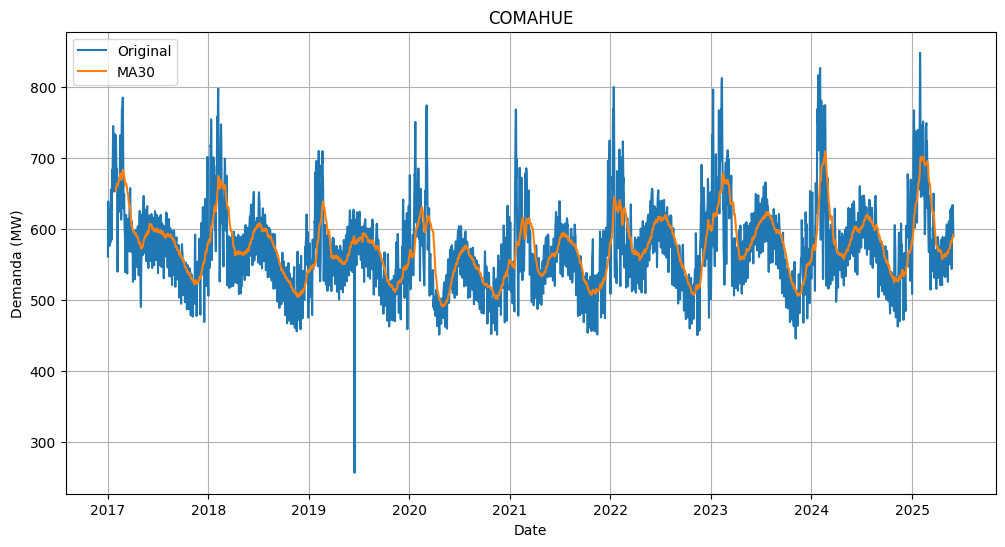

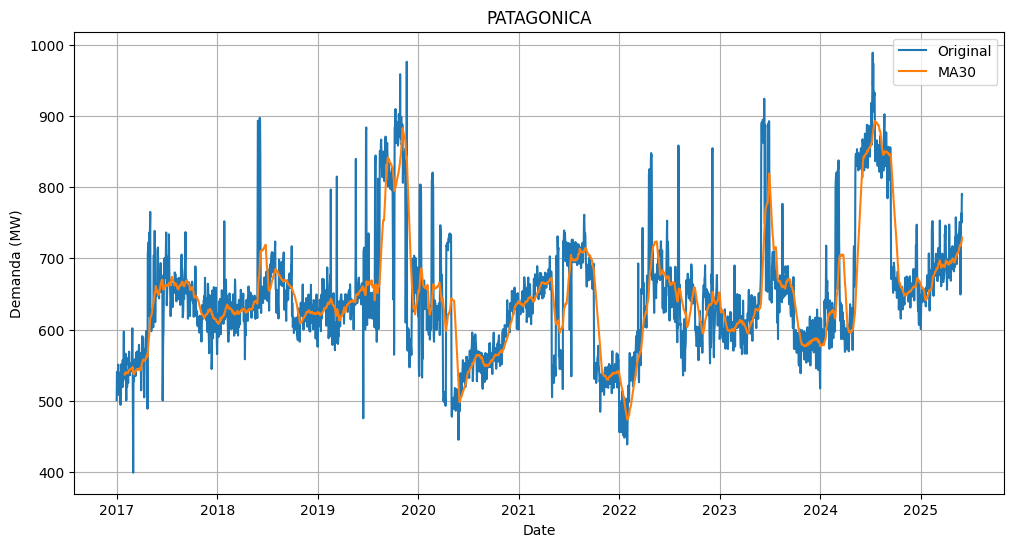

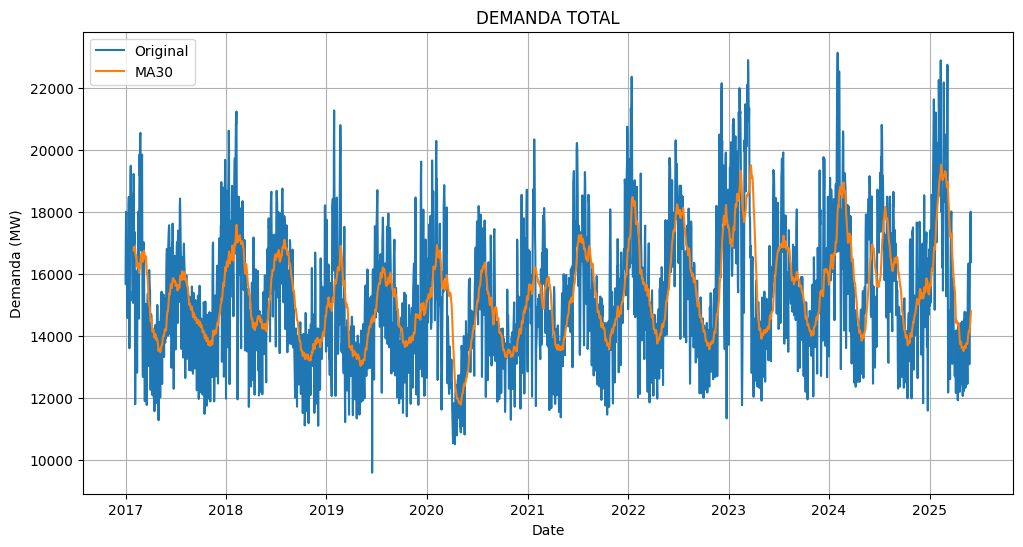

In [22]:
for col, serie in series.items():
    serie['MA30'] = moving_average(serie['ORIGINAL'], 30)
    plot_moving_average(serie['ORIGINAL'], serie['MA30'], window=30, title=col)

# Test de estacionalidad
### Utilizamos ADF y KPSS

In [23]:
for col, serie in series.items():
    serie['SEASONALITY'] = seasonality_tests(serie['ORIGINAL'])
    print_stationarity_tests(results=serie['SEASONALITY'], name=serie['APODO'])
    print('-----------------------------------------------------------')

[ADF](0.00)		AMBA		Es estacionaria
[KPSS](0.10)		AMBA		Es estacionaria
-----------------------------------------------------------
[ADF](0.00)		CABA		Es estacionaria
[KPSS](0.01)		CABA		No es estacionaria
-----------------------------------------------------------
[ADF](0.00)		CENTRO		Es estacionaria
[KPSS](0.01)		CENTRO		No es estacionaria
-----------------------------------------------------------
[ADF](0.00)		LITORAL		Es estacionaria
[KPSS](0.04)		LITORAL		No es estacionaria
-----------------------------------------------------------
[ADF](0.00)		CUYO		Es estacionaria
[KPSS](0.10)		CUYO		Es estacionaria
-----------------------------------------------------------
[ADF](0.00)		NOESTE		Es estacionaria
[KPSS](0.01)		NOESTE		No es estacionaria
-----------------------------------------------------------
[ADF](0.00)		NESTE		Es estacionaria
[KPSS](0.02)		NESTE		No es estacionaria
-----------------------------------------------------------
[ADF](0.00)		COMAHUE		Es estacionaria
[KPSS](0.06)		

# Parcialmente estacionaria
### Podemos aplicarle diferenciación

In [24]:
for col, serie in series.items():
    serie['DIFF'] = differentiate(serie['ORIGINAL'])
    serie['DIFF_SEASONALITY'] = seasonality_tests(serie['DIFF'])
    print_stationarity_tests(results=serie['DIFF_SEASONALITY'], name=serie['APODO'])
    print('-----------------------------------------------------------')

[ADF](0.00)		AMBA		Es estacionaria
[KPSS](0.10)		AMBA		Es estacionaria
-----------------------------------------------------------
[ADF](0.00)		CABA		Es estacionaria
[KPSS](0.10)		CABA		Es estacionaria
-----------------------------------------------------------
[ADF](0.00)		CENTRO		Es estacionaria
[KPSS](0.10)		CENTRO		Es estacionaria
-----------------------------------------------------------
[ADF](0.00)		LITORAL		Es estacionaria
[KPSS](0.10)		LITORAL		Es estacionaria
-----------------------------------------------------------
[ADF](0.00)		CUYO		Es estacionaria
[KPSS](0.10)		CUYO		Es estacionaria
-----------------------------------------------------------
[ADF](0.00)		NOESTE		Es estacionaria
[KPSS](0.10)		NOESTE		Es estacionaria
-----------------------------------------------------------
[ADF](0.00)		NESTE		Es estacionaria
[KPSS](0.10)		NESTE		Es estacionaria
-----------------------------------------------------------
[ADF](0.00)		COMAHUE		Es estacionaria
[KPSS](0.10)		COMAHUE		Es est

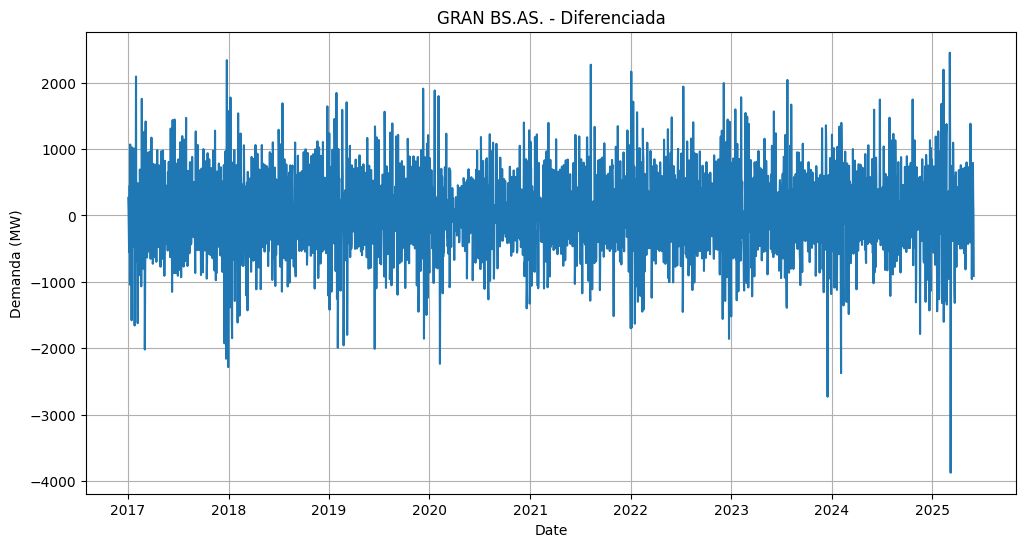

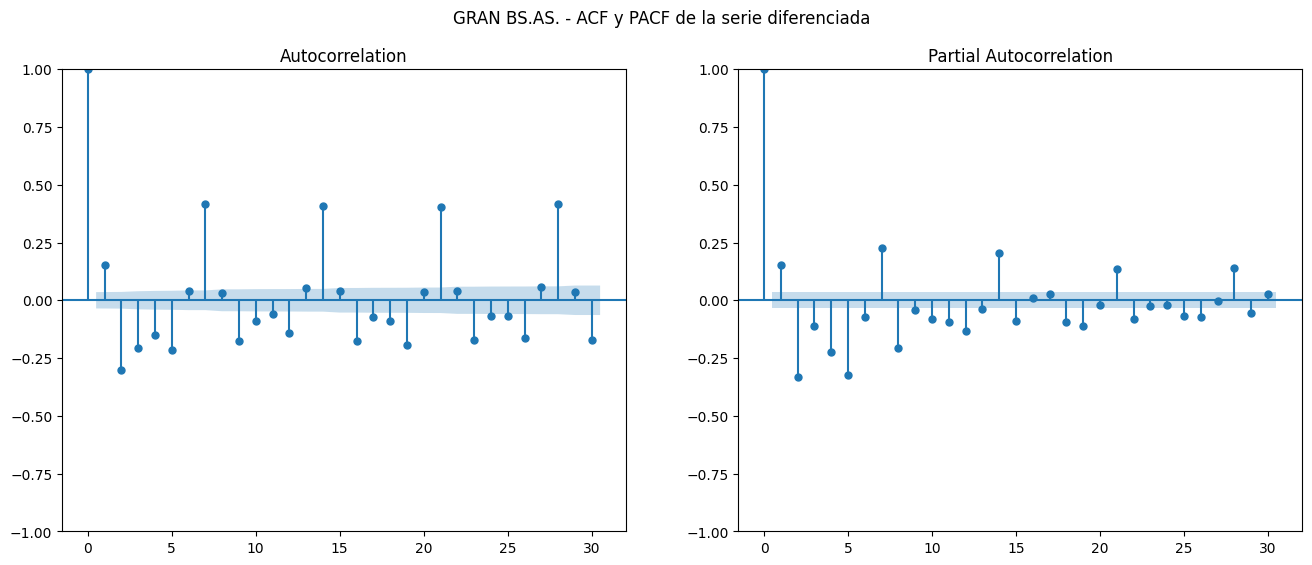

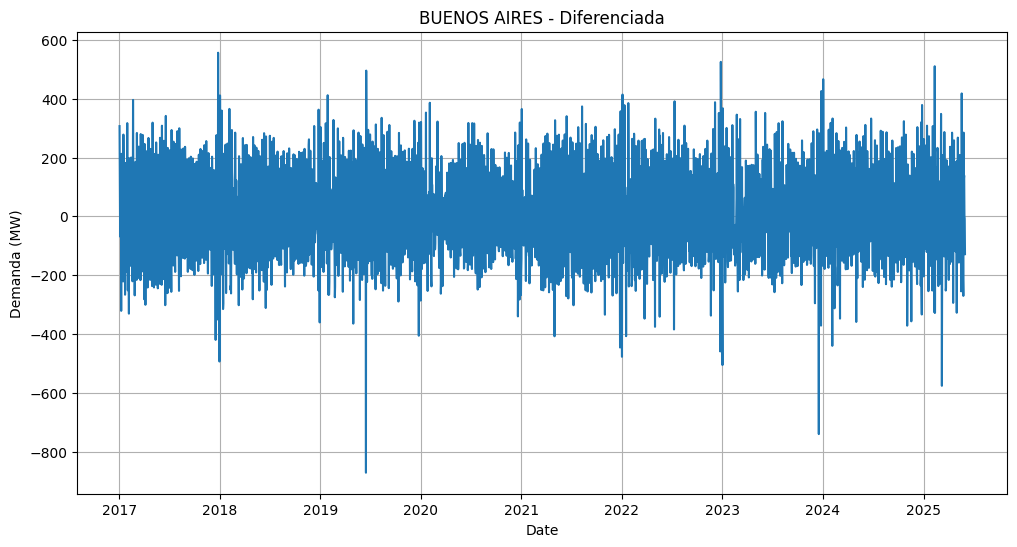

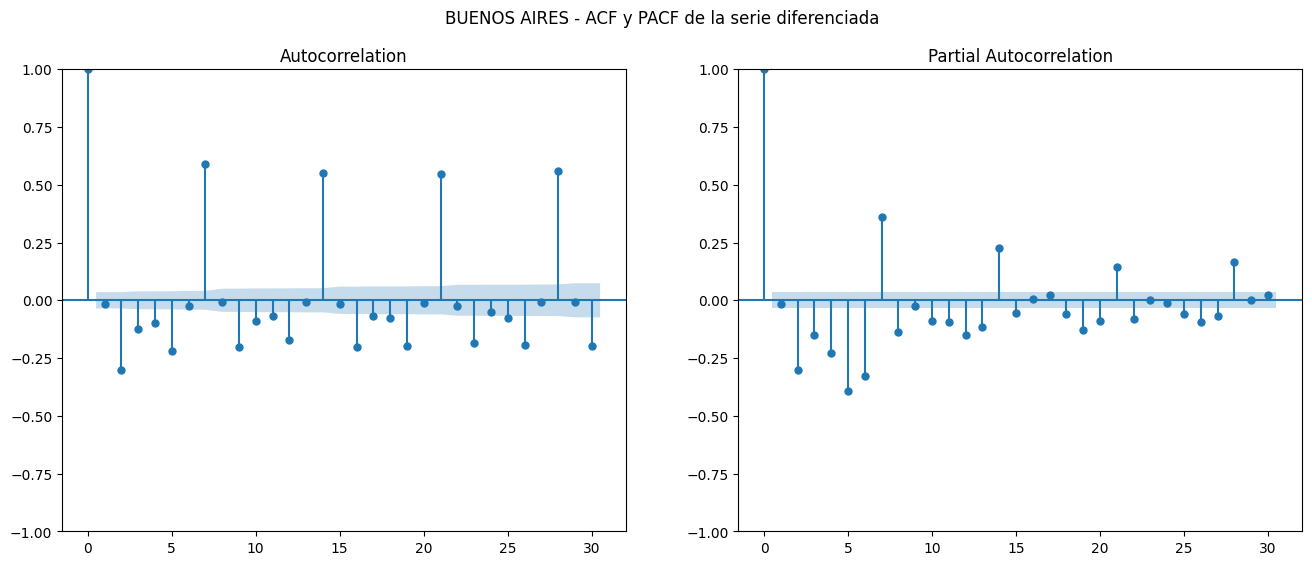

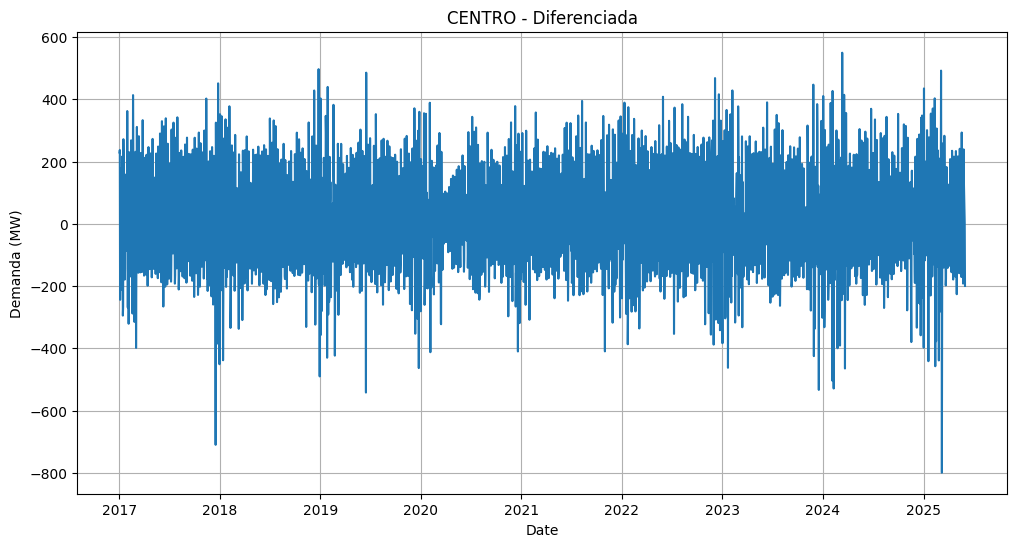

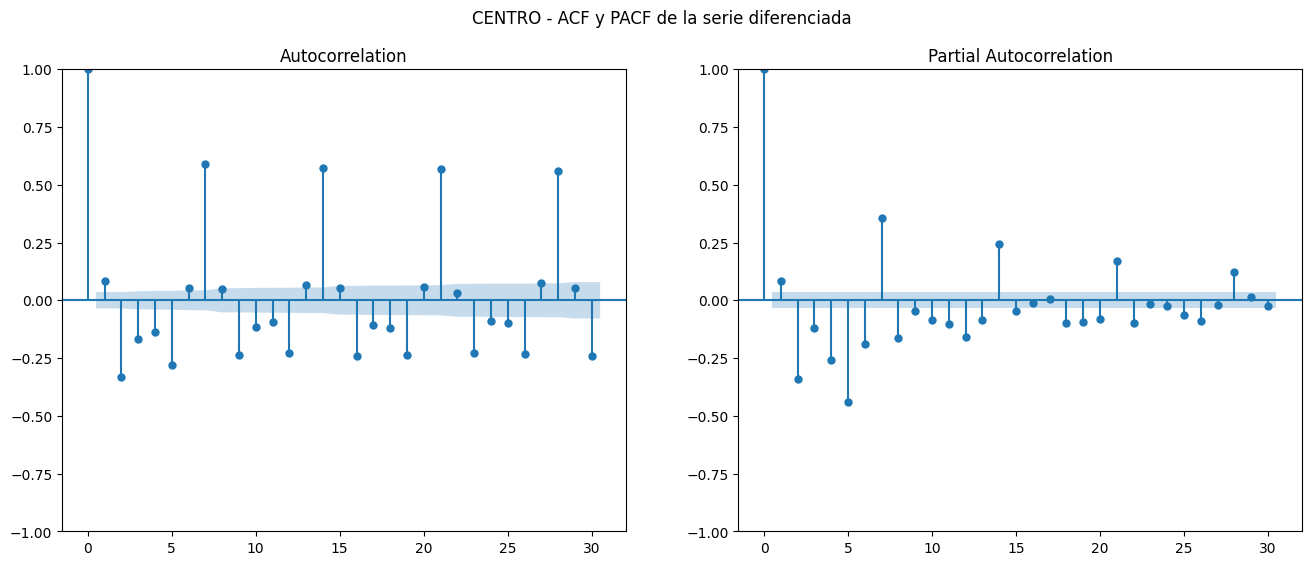

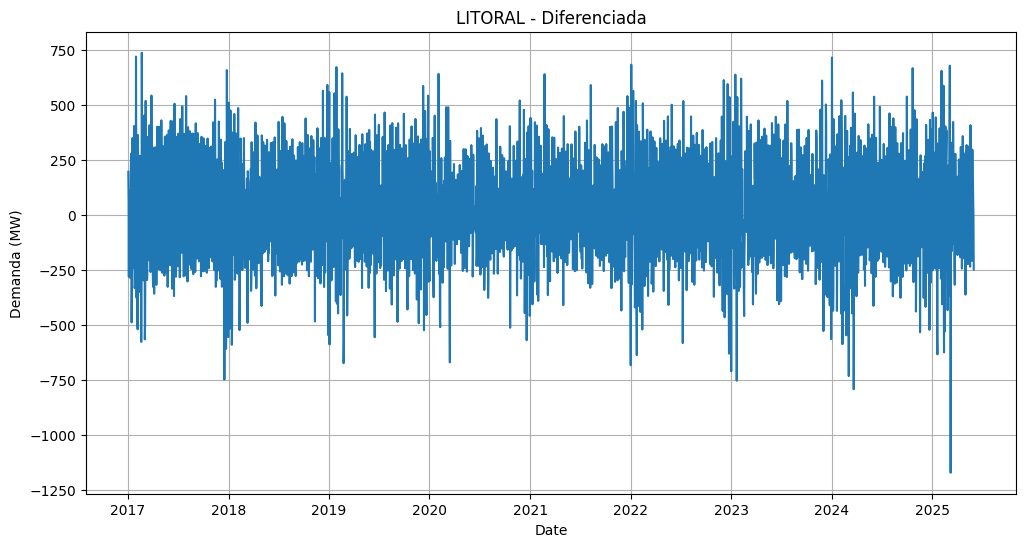

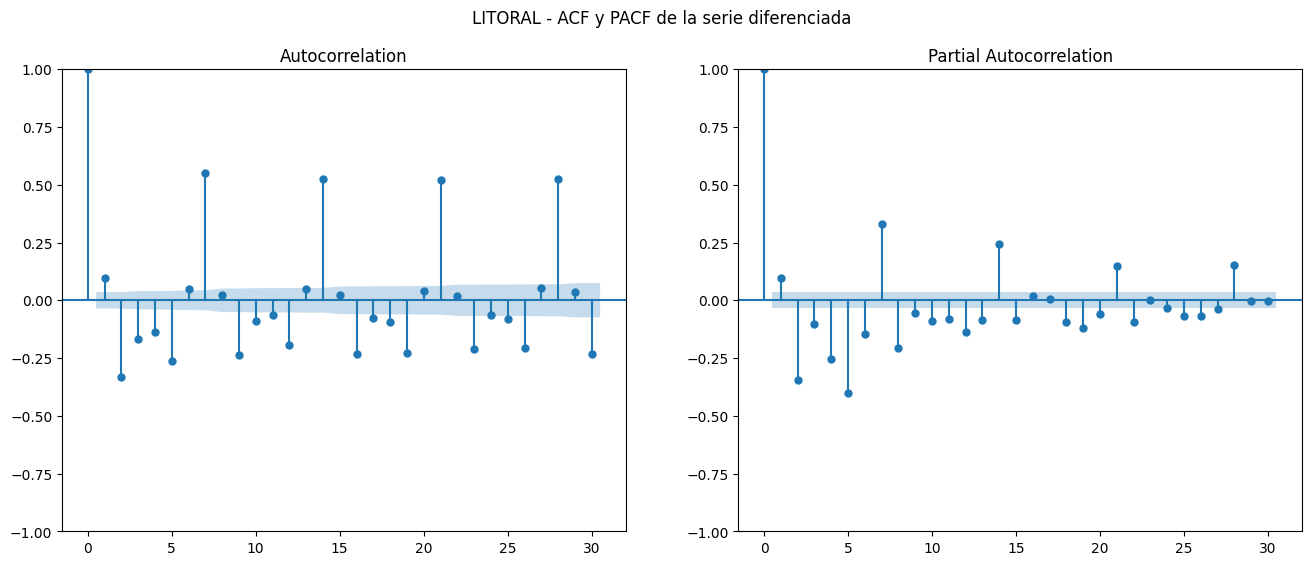

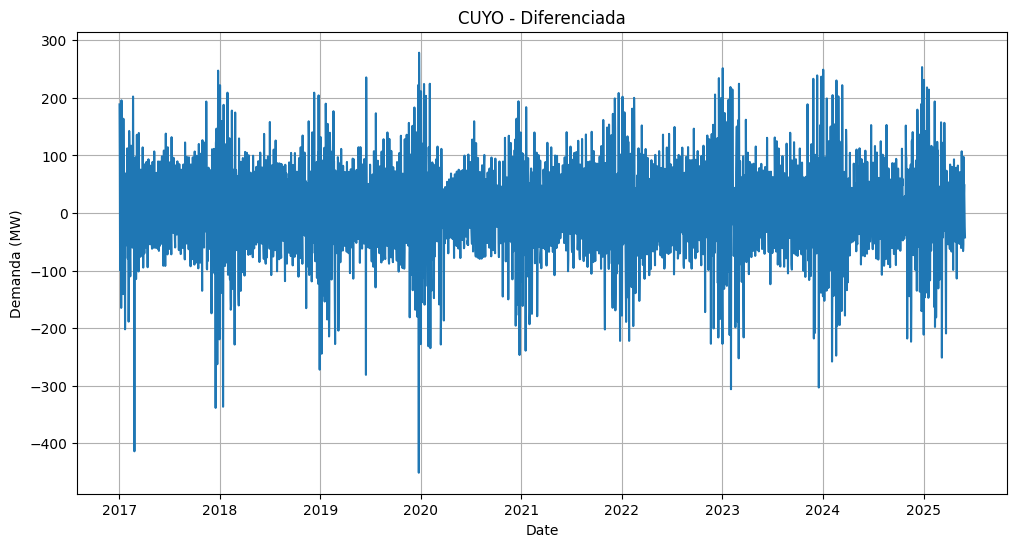

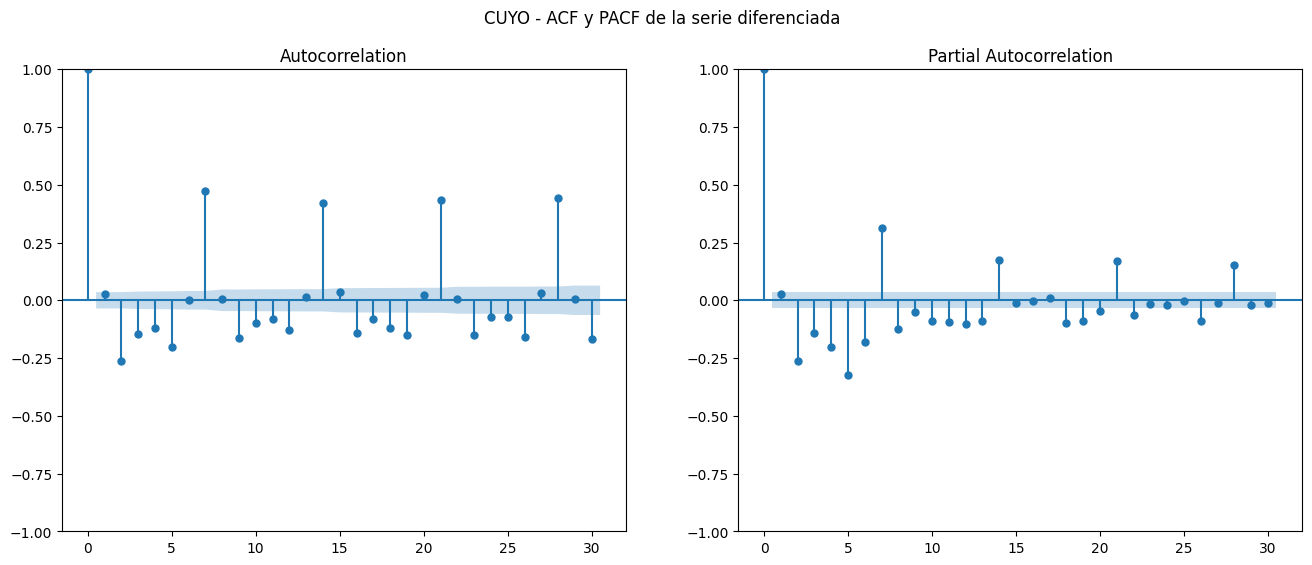

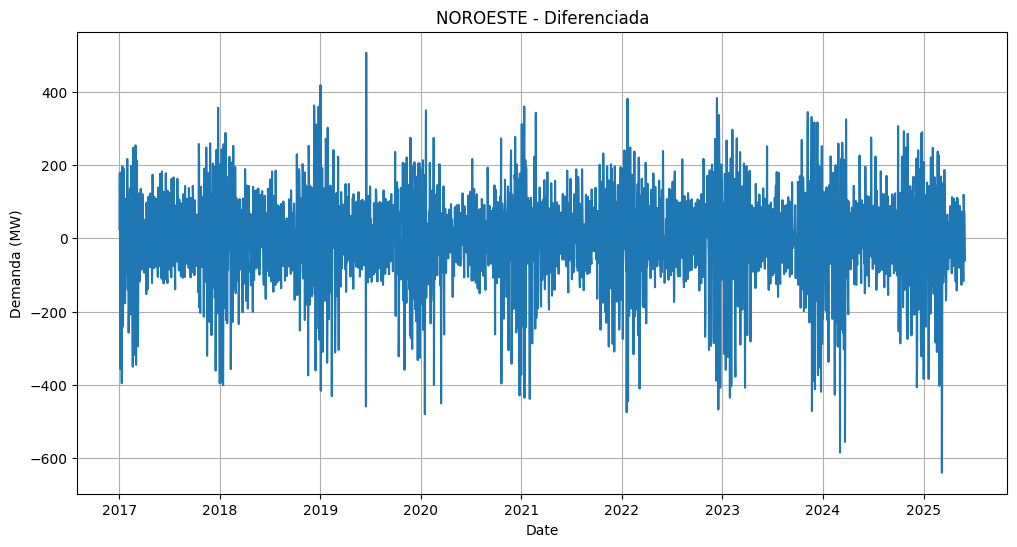

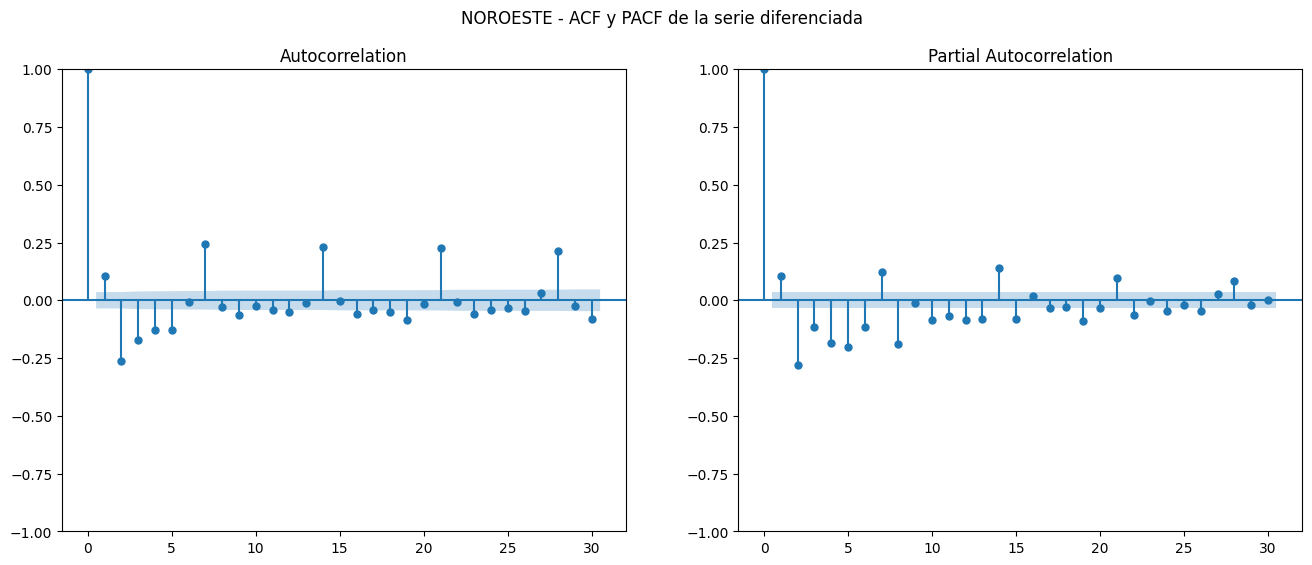

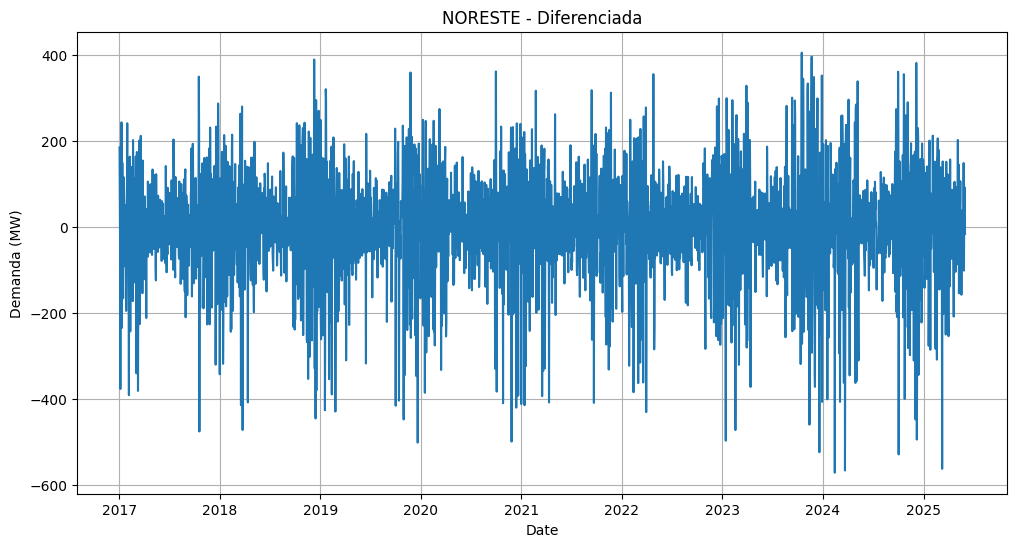

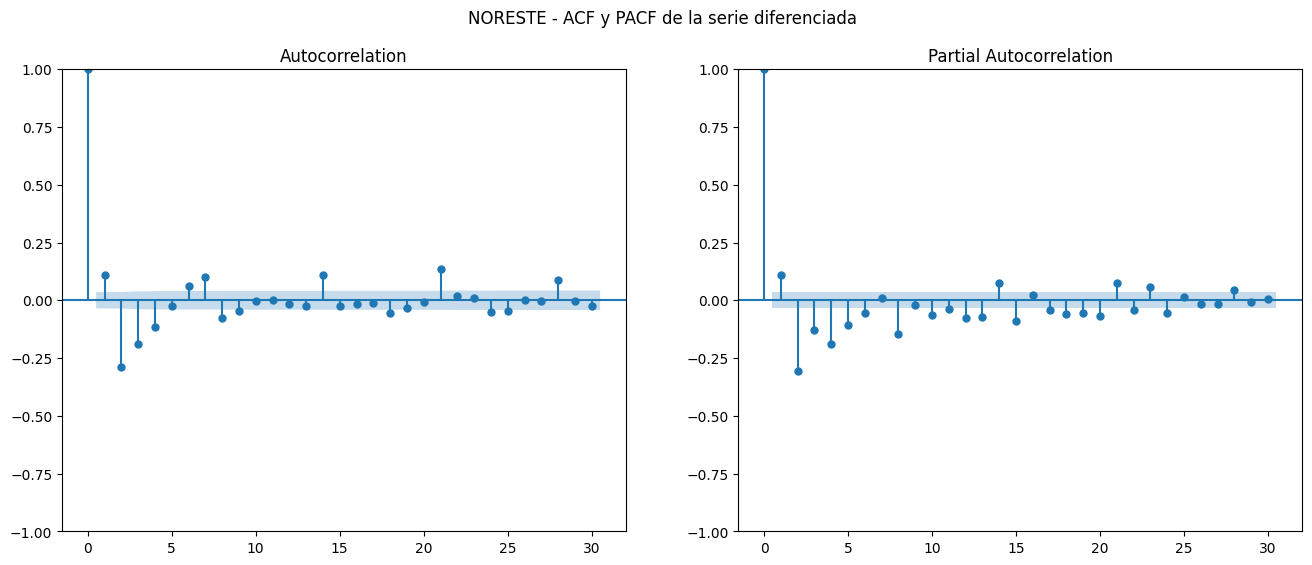

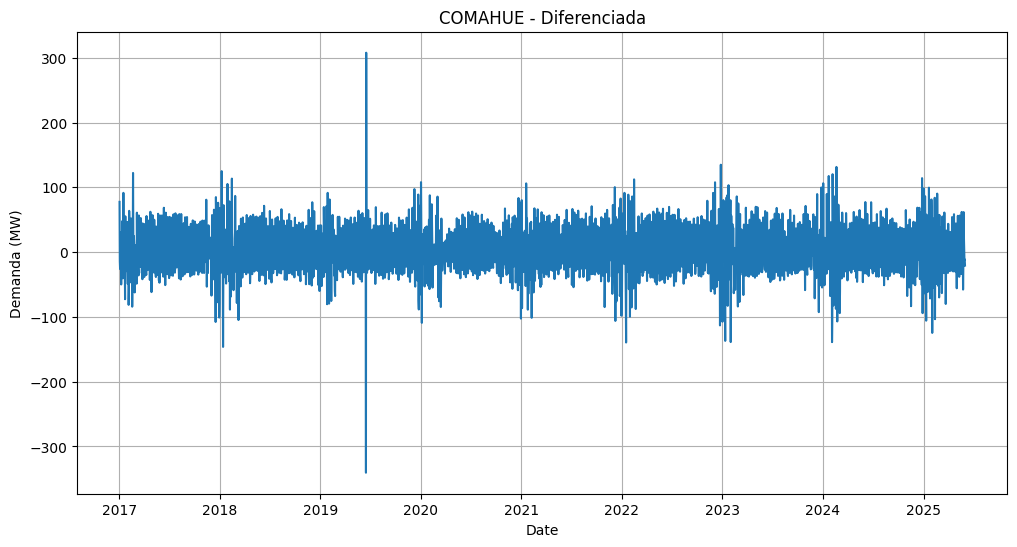

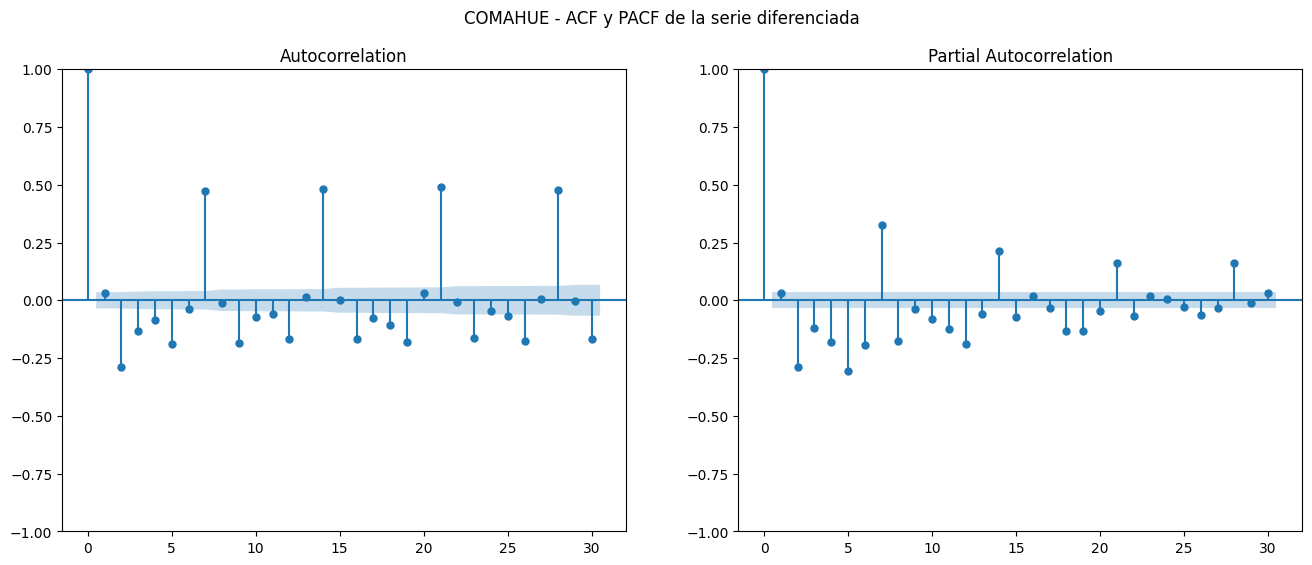

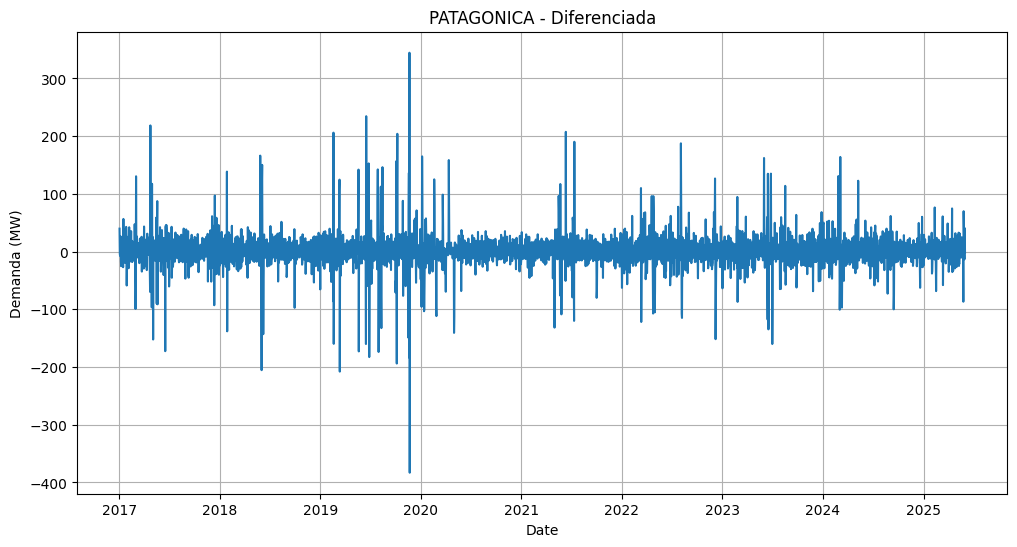

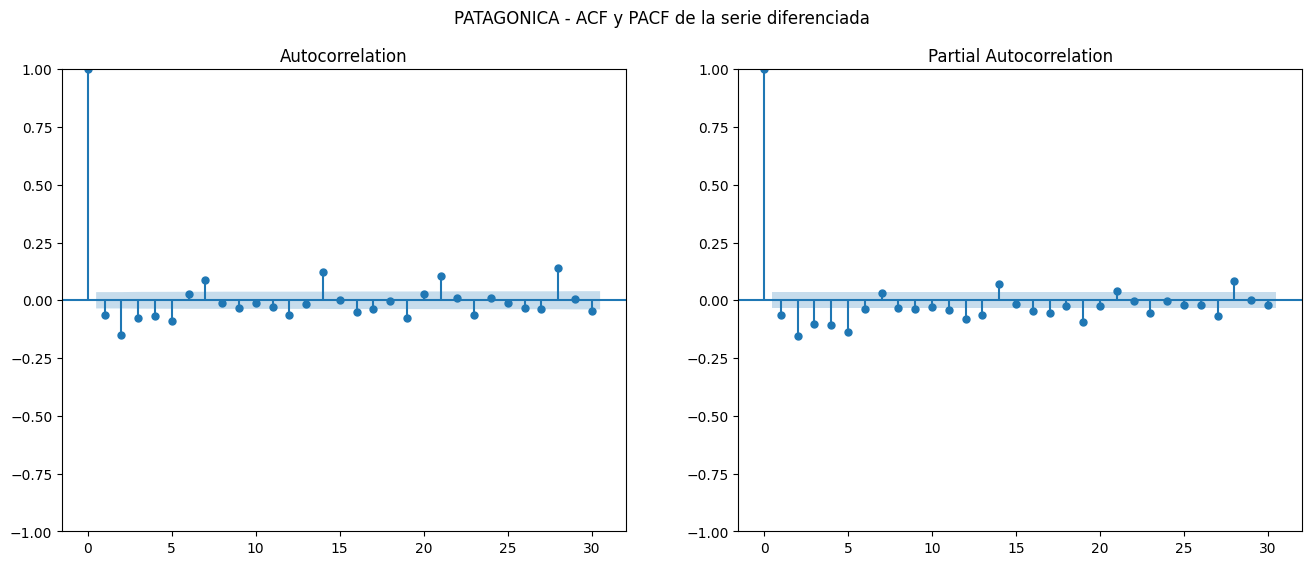

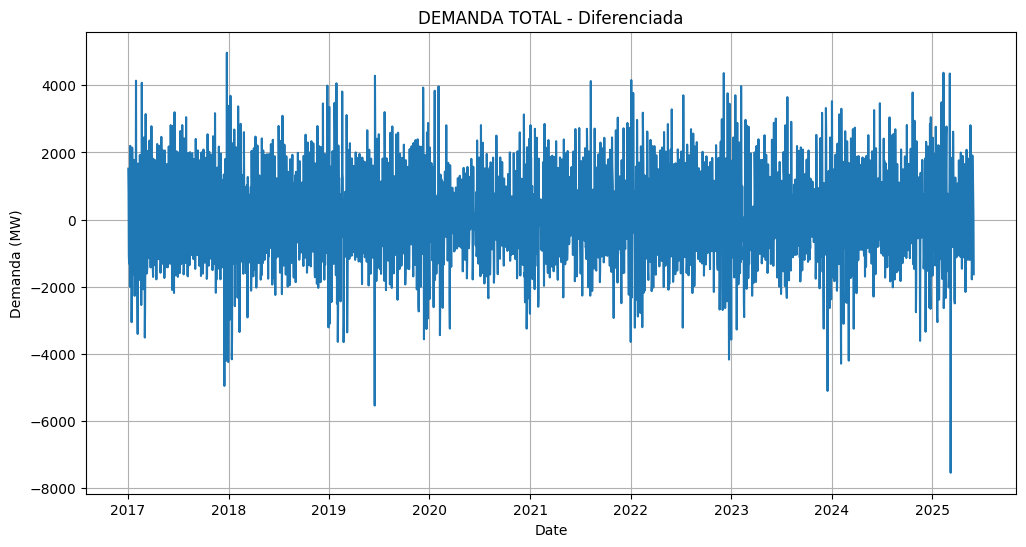

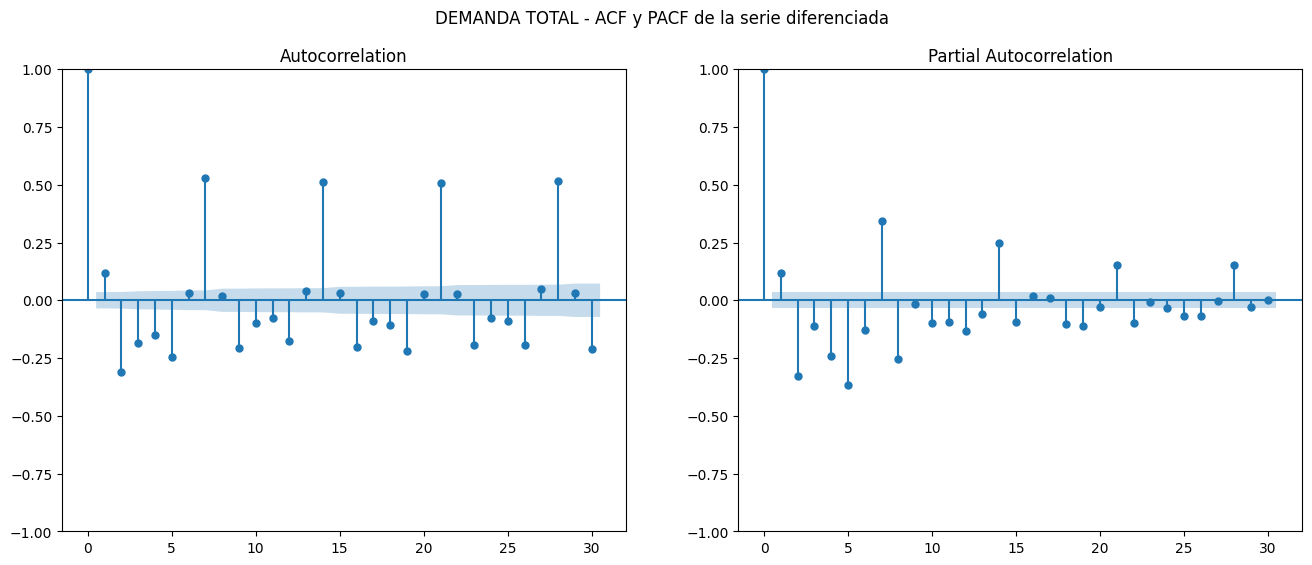

In [25]:
for col, serie in series.items():
    plot_series(serie['DIFF'], title=f"{col} - Diferenciada")
    # plot_acf_pacf(serie['ORIGINAL'], lags=30, title=f"{col} - ACF y PACF de la serie original")
    plot_acf_pacf(serie['DIFF'], lags=30, title=f"{col} - ACF y PACF de la serie diferenciada")

# Separamos datos de entrenamiento
### 70-30 como el fernet

In [ ]:
for col, serie in series.items():
    serie['TRAIN'], serie['TEST'] = train_test_split(serie['ORIGINAL'], test_size=0.3)
    # serie['FITTED'] = fit_arima(serie['TRAIN'], order=(1, 1, 1))
    serie['FITTED'] = fit_sarima(serie['TRAIN'], order=(7, 1, 1), seasonal_order=(7, 1, 1, 7))
    serie['FORECAST_SARIMA'], serie['CONF_INT_SARIMA'] = forecast_arima(serie['FITTED'], start=serie['TEST'].index[0], steps=len(serie['TEST']), periods=len(serie['TEST']))
    plot_arima_forecast(serie['TRAIN'], 
                        serie['TEST'], 
                        serie['FORECAST_SARIMA'], 
                        serie['CONF_INT_SARIMA'], 
                        title=f"{col} - ARIMA")

ValueError: Invalid model: autoregressive lag(s) {np.int64(7)} are in both the seasonal and non-seasonal autoregressive components.

# (S)ARIMA nos anda mal...
### TODO: Evaluar los parámetros, preguntarle a Risk

# Descomposición Tendencia + Estacionalidad + Residuo

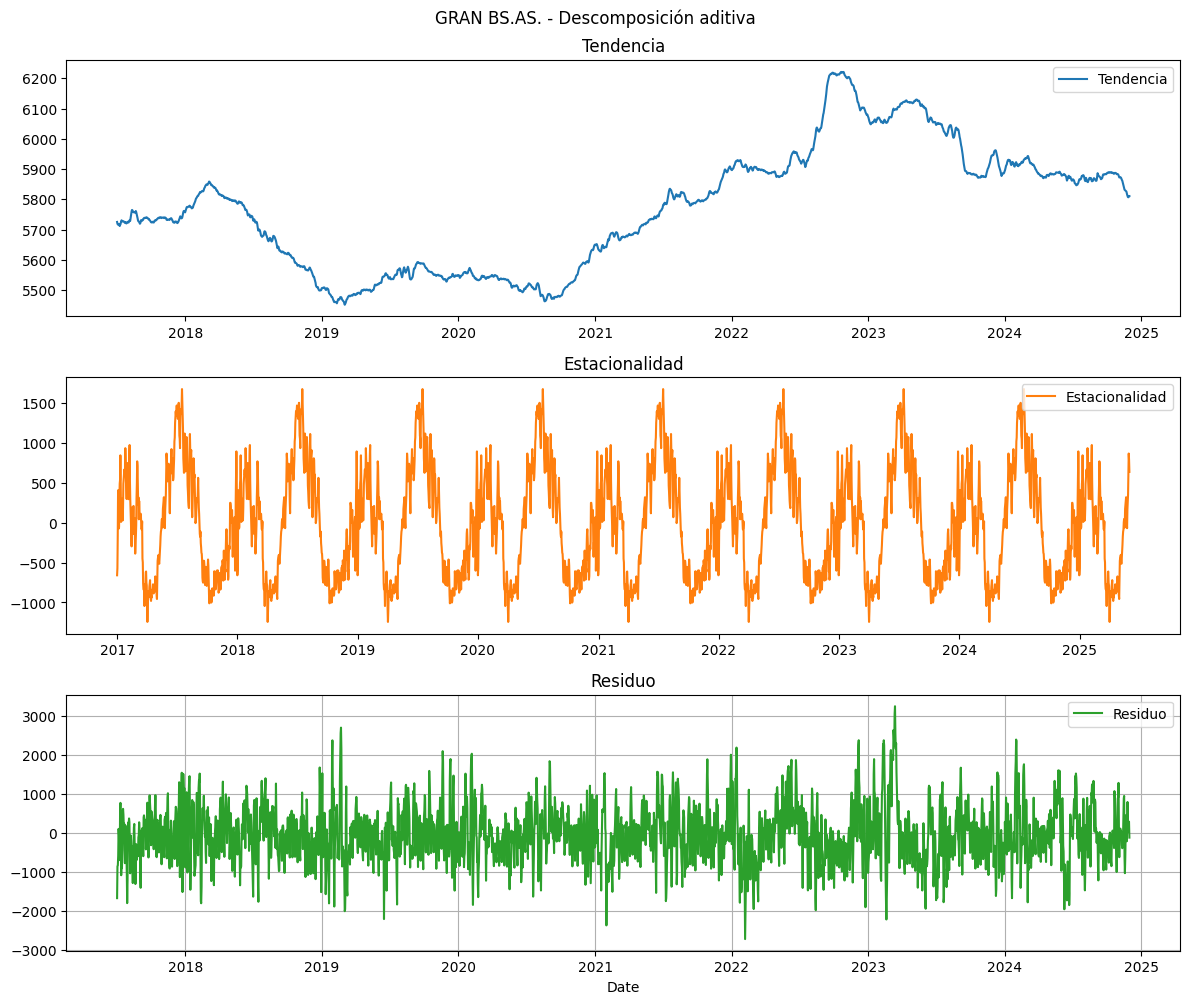

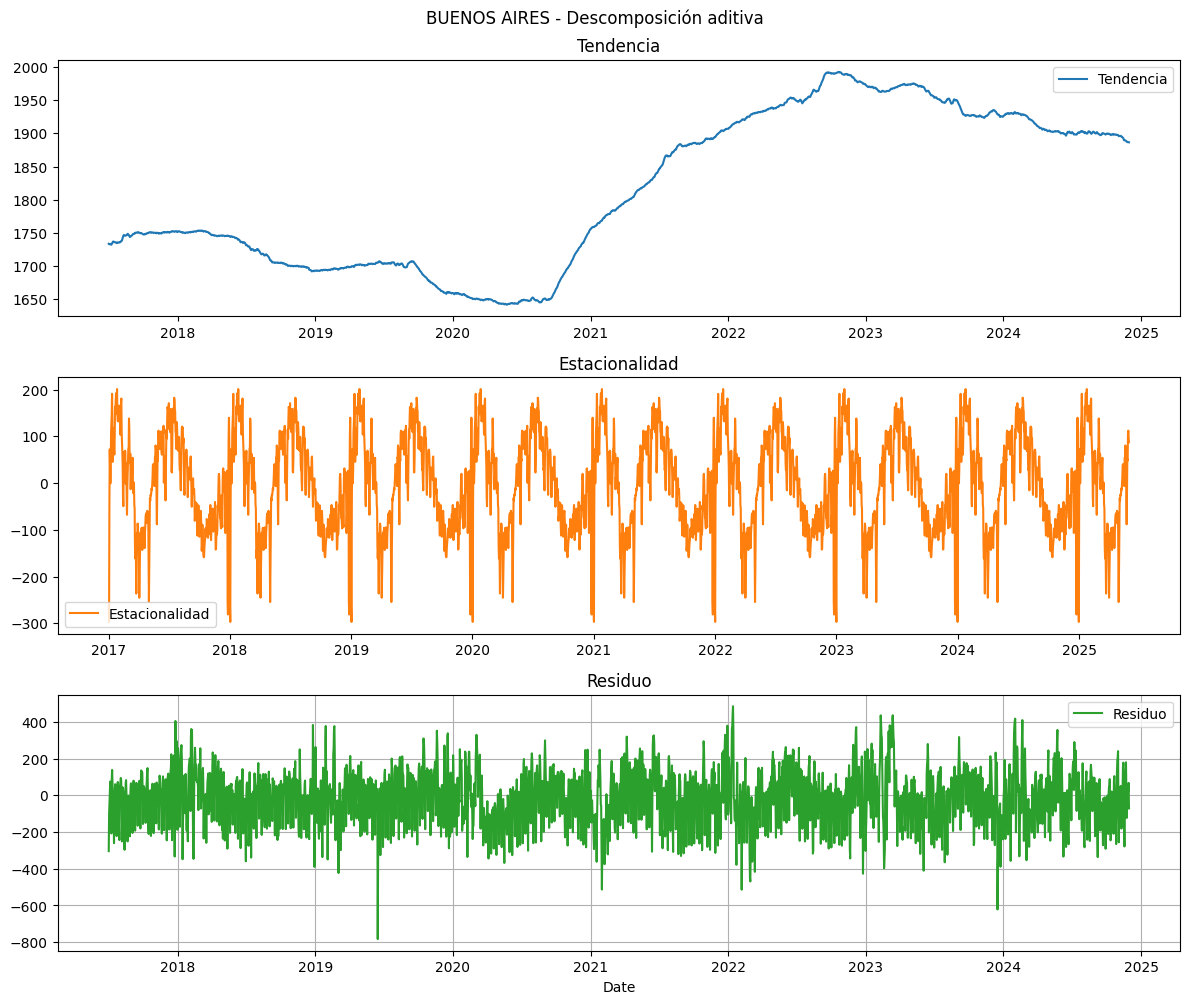

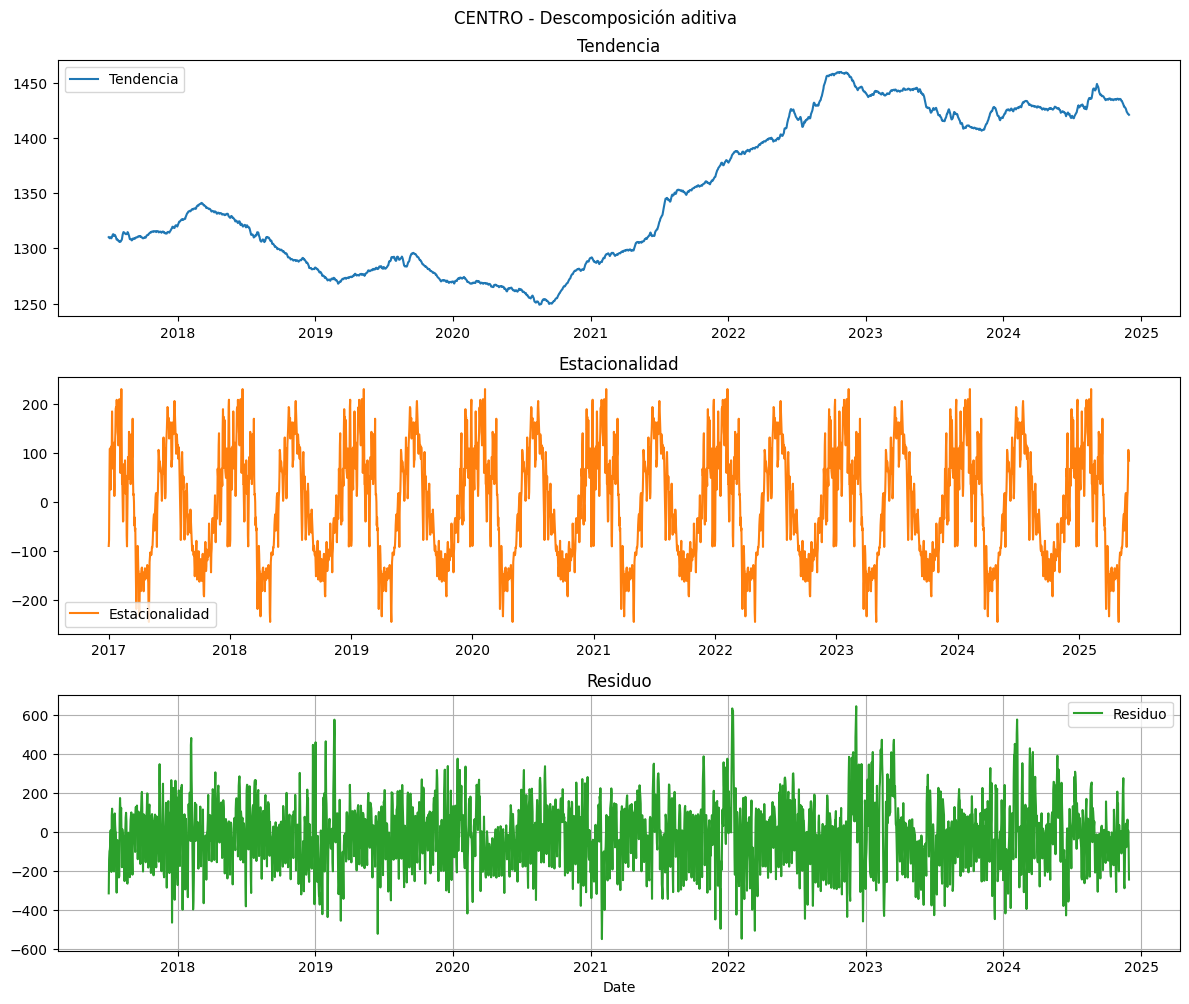

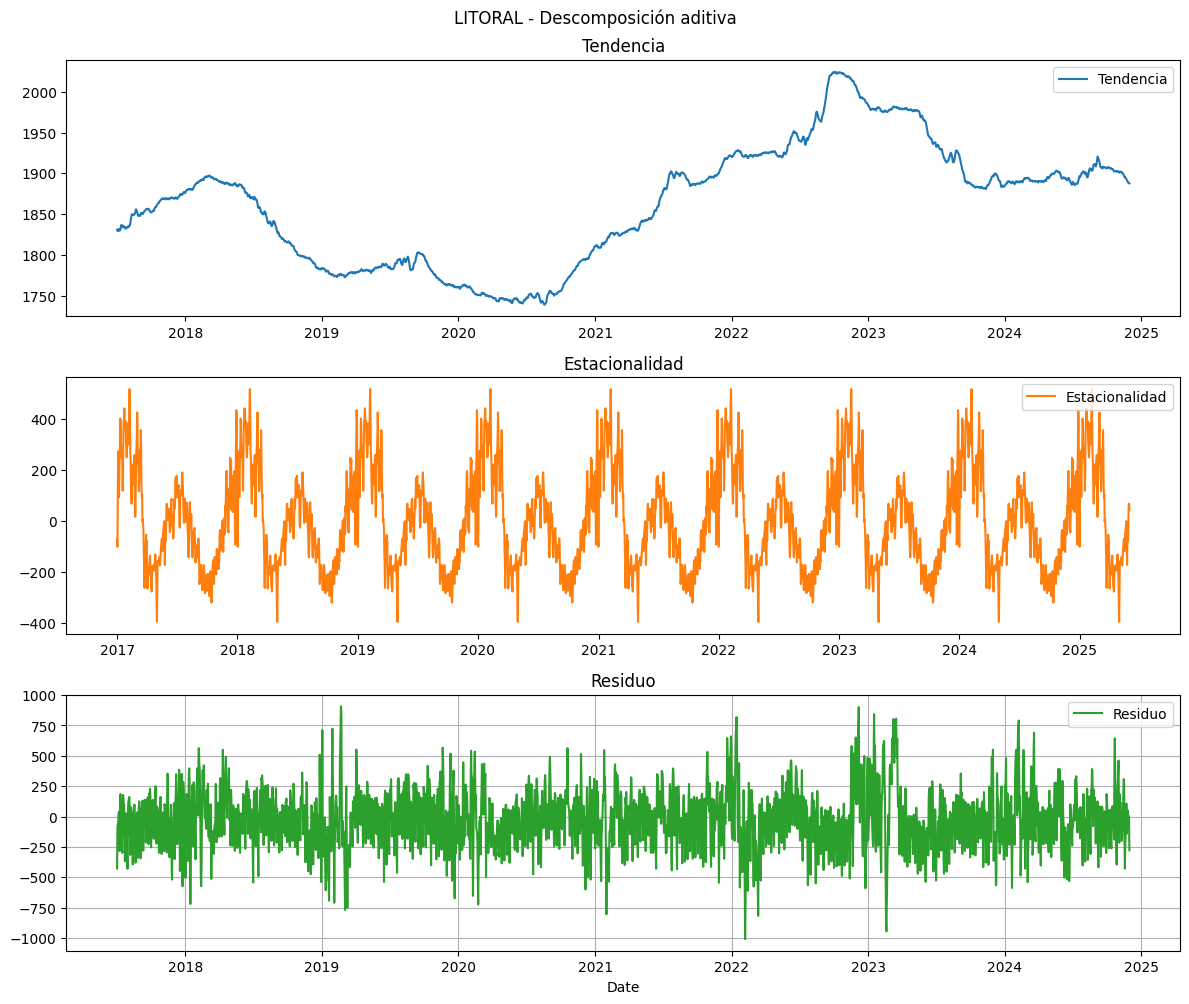

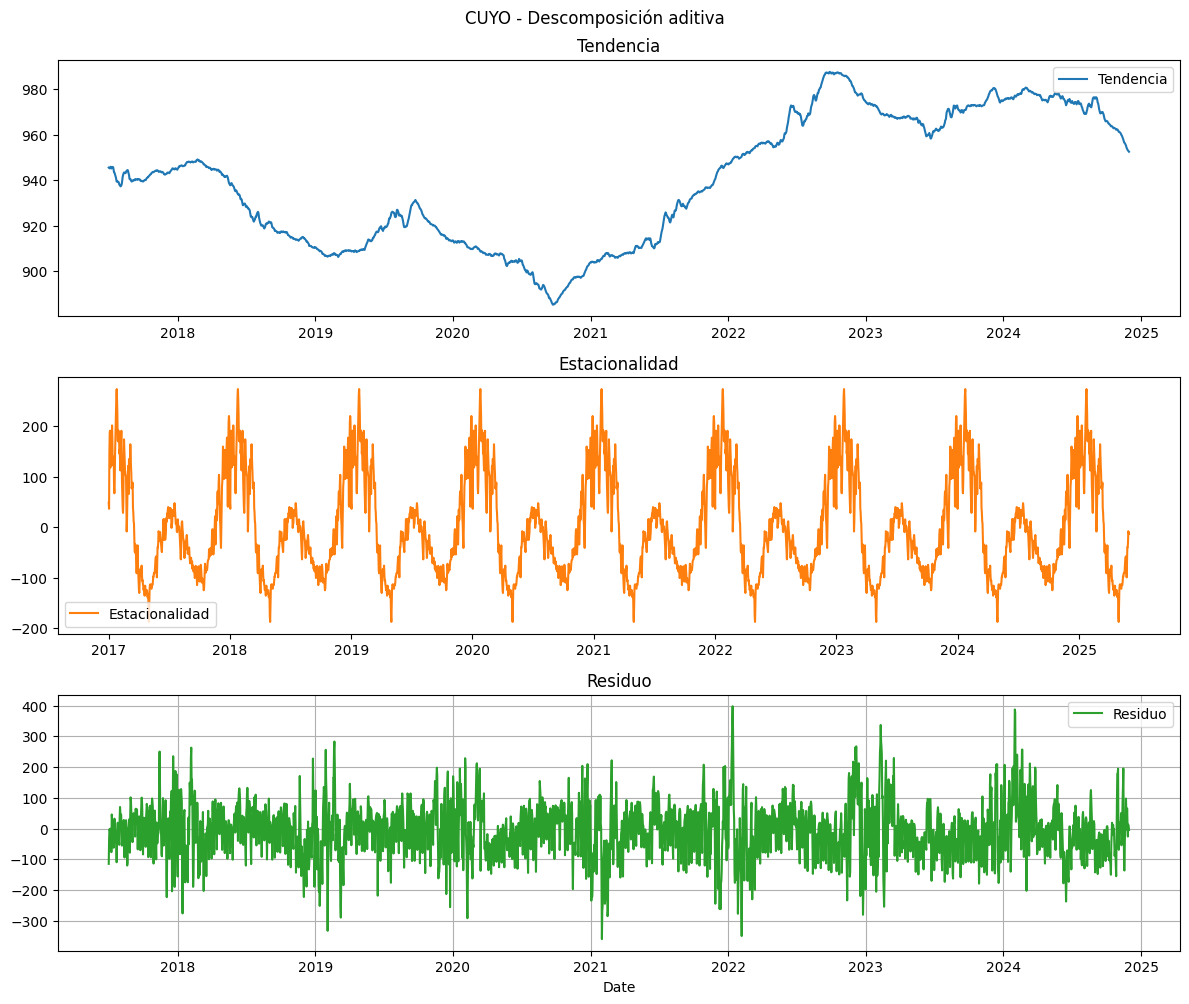

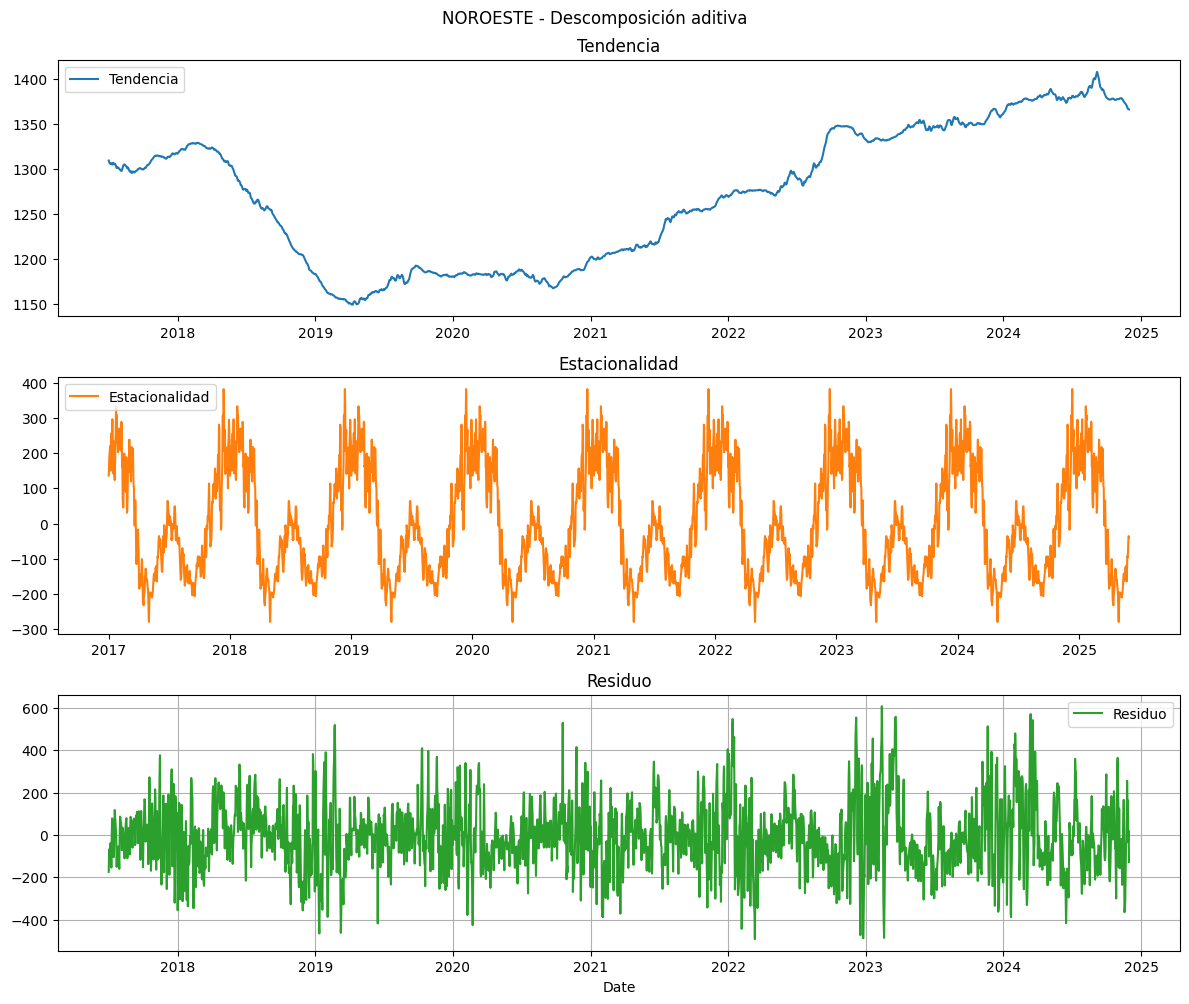

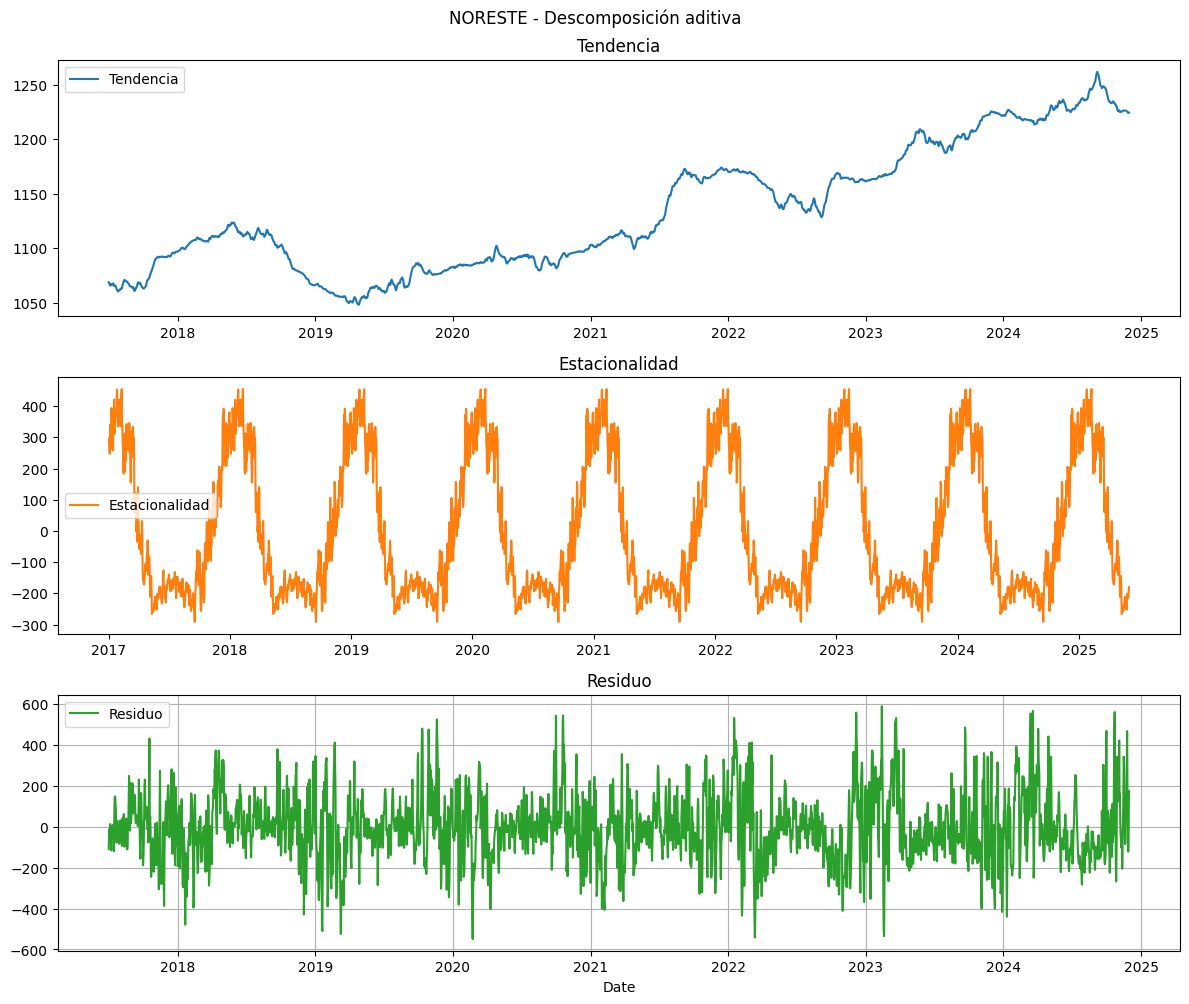

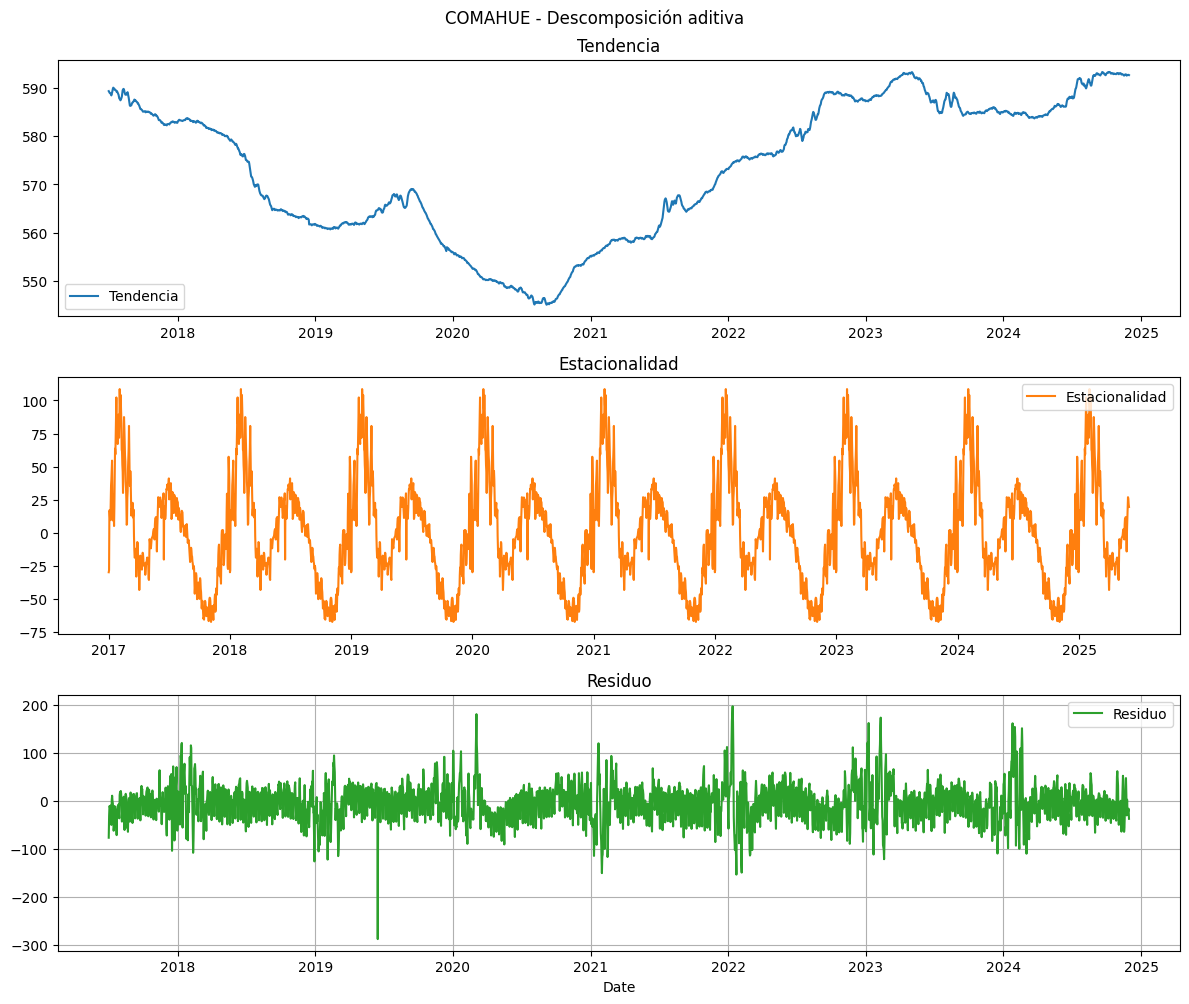

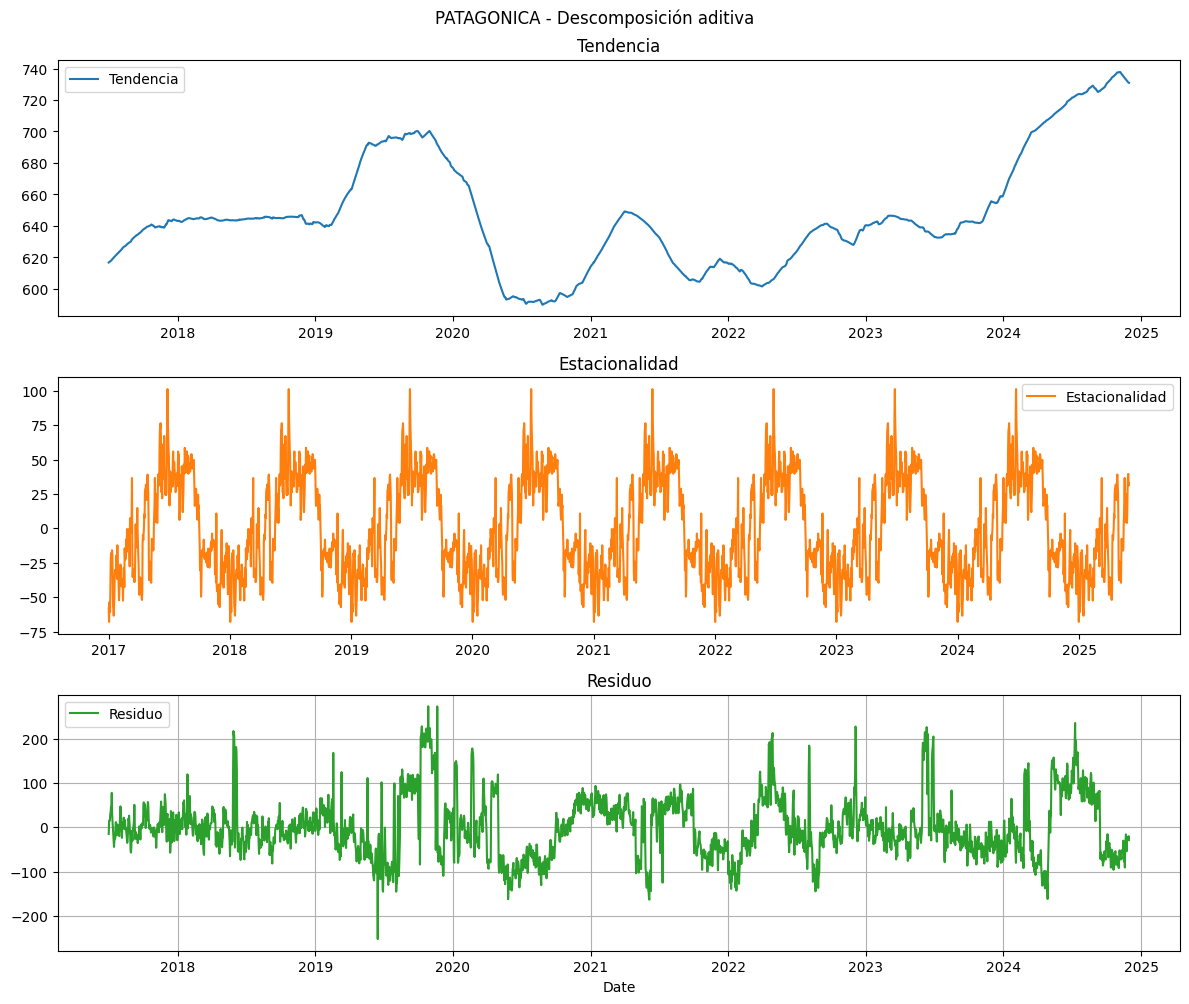

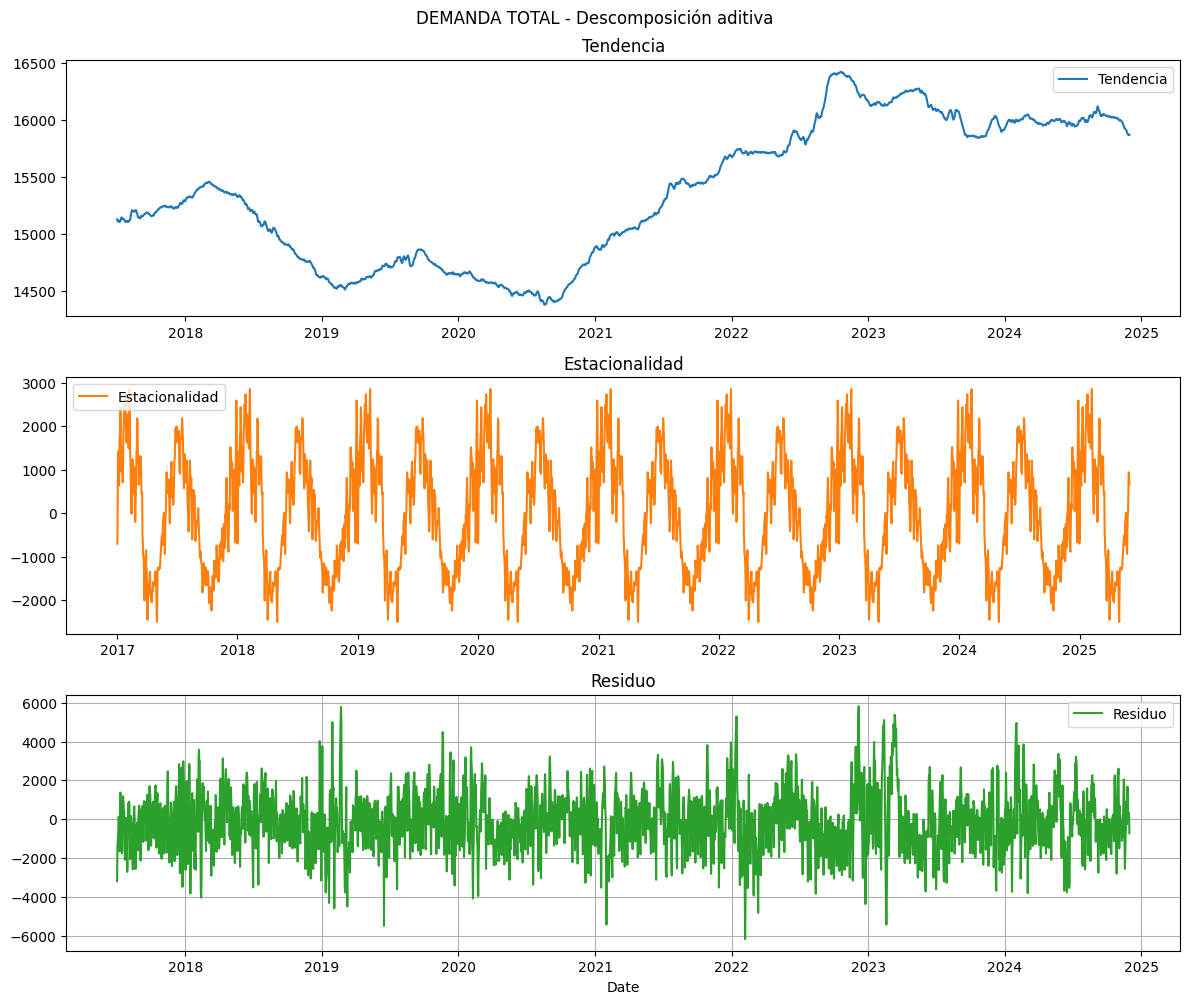

In [13]:
for col, serie in series.items():
    serie['DECOMPOSED'] = decompose_series(serie['ORIGINAL'], model='additive', period=365)
    plot_decomposition_2(serie['DECOMPOSED'], title=f"{col} - Descomposición aditiva")

# TODO:
* [] Prophet
* [] Normalización gráficos (mismo mínimo/máximo) para facilitar la comparativa